In [3]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

import gc
import os
import re
import time


import s2sphere
from tqdm import tqdm_notebook
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/work/github/gojek_takehome/infra/creds/serviceaccount.json"

import pandas as pd

from google.cloud import bigquery
from google.cloud import storage
client = bigquery.Client()
storage_client = storage.Client()

%load_ext rpy2.ipython
%load_ext google.cloud.bigquery

# Problem Statement

For this take home, we will be building a microservice with 3 endpoints. The results they return will be based on the following tables found in GCP's BIGQUERY public data sets.


| Tables |
| --- |
| tlc_green_trips_2014 |
| tlc_green_trips_2015 |
| tlc_green_trips_2016 |
| tlc_green_trips_2017 |
| tlc_yellow_trips_2015 |
| tlc_yellow_trips_2016 |
| tlc_yellow_trips_2017 |

In [4]:
# Green taxis
greens = "tlc_green_trips_{YEAR}"
tables = [greens.format(YEAR=year) for year in [2014, 2015, 2016, 2017]]
# Yellow taxis
yellows = "tlc_yellow_trips_{YEAR}"
tables.extend([yellows.format(YEAR=year) for year in [2015, 2016, 2017]])
tables

['tlc_green_trips_2014',
 'tlc_green_trips_2015',
 'tlc_green_trips_2016',
 'tlc_green_trips_2017',
 'tlc_yellow_trips_2015',
 'tlc_yellow_trips_2016',
 'tlc_yellow_trips_2017']

Lets check out how the table looks like:

In [10]:
%%bigquery

SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2014` LIMIT 5

,vendor_id,pickup_datetime,dropoff_datetime,store_and_fwd_flag,rate_code,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,...,mta_tax,tip_amount,tolls_amount,ehail_fee,total_amount,payment_type,distance_between_service,time_between_service,trip_type,imp_surcharge
0,1,2014-06-07 12:26:15,2014-06-07 13:09:31,N,1,-73.870522,40.733963,-73.737892,40.754864,1,...,0.5,0.0,0.0,None,29.0,2,None,None,1.0,None
1,1,2014-12-18 15:28:43,2014-12-18 16:15:25,N,1,-73.967270,40.695385,-73.782303,40.648777,1,...,0.5,8.5,0.0,None,51.0,1,None,None,1.0,None
2,1,2014-03-23 01:28:58,2014-03-23 01:56:27,N,1,-73.946854,40.692650,-73.989410,40.758247,1,...,0.5,2.5,0.0,None,30.0,1,None,None,NaN,None
3,1,2014-11-14 17:01:33,2014-11-14 17:36:02,N,1,-74.000198,40.685997,-73.956543,40.747772,1,...,0.5,5.6,0.0,None,33.6,1,None,None,1.0,None
4,2,2014-06-29 12:57:00,2014-06-29 13:28:33,N,1,-73.954750,40.718643,-73.986366,40.669212,1,...,0.5,0.0,0.0,None,26.0,2,None,None,1.0,None


## Endpoint 1: Total trips per day


```bash
START_DATE=2019-01-01
END_DATE=2019-01-31

curl http://${URL}:${PORT}/total_trips?start=${START_DATE}&end=${END_DATE}
```

Returning

```json
{
   "data":[
      {
         "date":"2019-01-01",
         "total_trips":321
      },
      {
         "date":"2019-01-02",
         "total_trips":432
      },
      {
         "date":"2019-01-03",
         "total_trips":543
      },
      {
         "date":"2019-01-31",
         "total_trips":987
      }
   ]
}
```

Example query:

In [127]:
%%bigquery

WITH num_pickups as (
    SELECT 
        CAST(pickup_datetime AS date) as date,
        COUNT(*)  as total_trips,
        2014 as year,
        'green' AS taxi_type
    FROM
        `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2014`
    GROUP BY CAST(pickup_datetime AS date)
)
SELECT 
    *
FROM num_pickups 
ORDER BY date
LIMIT 5

,date,total_trips,year,taxi_type
0,2014-01-01,25608,2014,green
1,2014-01-02,19061,2014,green
2,2014-01-03,13436,2014,green
3,2014-01-04,23697,2014,green
4,2014-01-05,20560,2014,green


We pull the following data using the following function:

In [3]:
def get_trips_per_day(tables):
    """
    Gets trip per day
    
    Summarises the # of trips per day in each table and 
    returns them as a concatenated pandas dataframe
    
    Parameters
    ------
    
    tables: list[str]
        list of table names
        
    Example
    ------
    >>> tables = [
        'tlc_green_trips_2014','tlc_green_trips_2015',
        'tlc_green_trips_2016','tlc_green_trips_2017',
        'tlc_yellow_trips_2015','tlc_yellow_trips_2016',
        'tlc_yellow_trips_2017'
        ]
    >>> df = get_trips_per_day(tables)
    """
    query = """
        WITH num_pickups as (
            SELECT 
            CAST(pickup_datetime AS date) as date,
            COUNT(*)  AS total_trips,
            {YEAR} AS year,
            '{COLOR}' AS color
        FROM
            `bigquery-public-data.new_york_taxi_trips.{TABLE}`
        GROUP BY CAST(pickup_datetime AS date)
        )
        SELECT * FROM num_pickups ORDER BY date
            """
    
    dfs = []
    for table in tables:
        (_, color, _, year) = re.split("_", table)
        dfs.append(client.query(
            query.format(
                TABLE=table, 
                YEAR=year,
                COLOR=color
            )
        ).to_dataframe())
    return pd.concat(dfs)

In [4]:
df = get_trips_per_day(tables)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2609 entries, 0 to 384
Data columns (total 4 columns):
date           2609 non-null object
total_trips    2609 non-null int64
year           2609 non-null int64
color          2609 non-null object
dtypes: int64(2), object(2)
memory usage: 101.9+ KB


,date,total_trips,year,color
0,2014-01-01,25608,2014,green
1,2014-01-02,19061,2014,green
2,2014-01-03,13436,2014,green
3,2014-01-04,23697,2014,green
4,2014-01-05,20560,2014,green


### Sanity Check


The data is dirty, some rows have timestamps outside of the year which the tables represent

2014-01-01 < Date 2018-1-1

In [5]:
firstdate = pd.to_datetime("2014-1-1").date()
lastdate = pd.to_datetime("2018-1-1").date()
outside_range = pd.concat([
    df.query('date < @firstdate'),
    df.query('date >= @lastdate')])
print("""
Earliest Date: {}
Latest Date: {}
Number of rows not in date range: {}
""".format(
    df.date.min().strftime("%Y-%m-%d"), 
    df.date.max().strftime("%Y-%m-%d"),
    outside_range.shape[0]
))


Earliest Date: 2001-01-01
Latest Date: 2053-03-21
Number of rows not in date range: 52



In [24]:
def get_total_trips_per_day(df, start_date="2014-1-1", end_date="2018-1-1"):
    firstdate = pd.to_datetime(start_date).date()
    lastdate = pd.to_datetime(end_date).date()
    cleaned_table = (df.query('@firstdate <= date < @lastdate')
        .loc[:, ['date', 'total_trips', 'color']]
        .groupby(['date', 'color'])
        .sum()
        .reset_index())
    return cleaned_table
counts_df = get_total_trips_per_day(df)

counts_df.head()

,date,color,total_trips
0,2014-01-01,green,25608
1,2014-01-02,green,19061
2,2014-01-03,green,13436
3,2014-01-04,green,23697
4,2014-01-05,green,20560


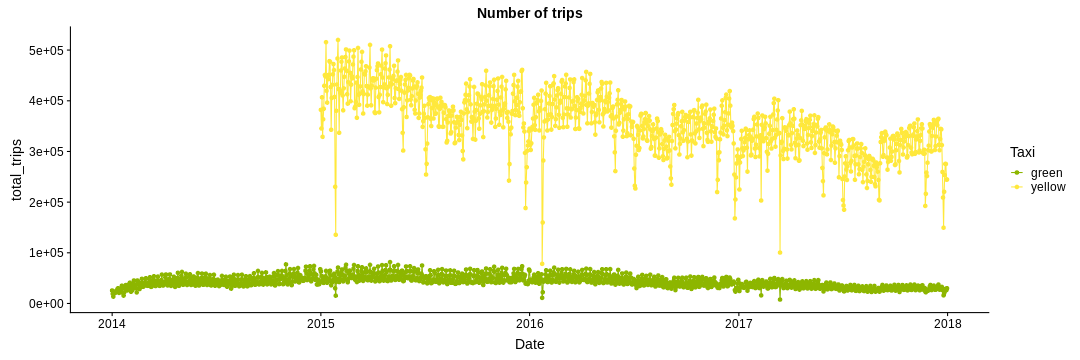

In [23]:
%%R -i counts_df -w 15 -h 5 -u in

suppressPackageStartupMessages({
    library(ggplot2)
    library(lubridate)
    library(cowplot)
})

ggplot(counts_df, aes(ymd(date), total_trips,  color=color)) +
    geom_line(aes(group=color)) +
    geom_point() +
    scale_color_manual("Taxi", values=c("#8db600", "#FFE83C")) +
    labs(title='Number of trips', x="Date")

> There seems to be much lesser data between in 2014 compared to the rest of the dates

For the route, we will be using the following function to return the data.

In [27]:
df.head()

,date,total_trips,year,color
0,2014-01-01,25608,2014,green
1,2014-01-02,19061,2014,green
2,2014-01-03,13436,2014,green
3,2014-01-04,23697,2014,green
4,2014-01-05,20560,2014,green


In [31]:
df = df.loc[:, ["date", "total_trips"]].groupby(["date"]).sum().reset_index()

In [32]:
def get_trips(df, start='2016-01-01', end='2016-01-10', return_json=False):
    firstdate = pd.to_datetime(start).date()
    lastdate = pd.to_datetime(end).date()
    trips = (df
         .query('@firstdate <= date < @lastdate')
         .loc[:,['date', 'total_trips']]
         .assign(date = lambda df: df.date.apply(lambda day: day.strftime("%Y-%m-%d")))
    )
    return trips.to_json(orient='records') if return_json else  trips.to_dict(orient='records')

In [33]:
get_trips(df)

[{'date': '2016-01-01', 'total_trips': 409433},
 {'date': '2016-01-02', 'total_trips': 359789},
 {'date': '2016-01-03', 'total_trips': 347148},
 {'date': '2016-01-04', 'total_trips': 359911},
 {'date': '2016-01-05', 'total_trips': 385593},
 {'date': '2016-01-06', 'total_trips': 390541},
 {'date': '2016-01-07', 'total_trips': 407705},
 {'date': '2016-01-08', 'total_trips': 443057},
 {'date': '2016-01-09', 'total_trips': 462686}]

## Endpoint 2: Fare heatmap


The average fare (fare_amount) per pick up location  [S2 ID](http://s2geometry.io/)  at level 16 for the given date.

```bash
DATE=2019-01-01

curl http://${URL}:${PORT}/average_fare_heatmap?date=${DATE}
```

```json
{
   "data":[
      {
         "s2id":"951977d37",
         "fare":13.21
      },
      {
         "s2id":"951977d39",
         "fare":4.32
      },
      {
         "s2id":"951977d40",
         "fare":5.43
      },
      {
         "s2id":"951978321",
         "fare":9.87
      }
   ]
}
```


### S2 ID

We will be using the `s2sphere` package to convert the latitutde and longitude values to unique S2 Cell Ids

**Example**: 

Let's make use of Singapore's LatLng:



In [5]:
latlong = (1.3521, 103.8198)
pos = s2sphere.LatLng.from_degrees(*latlong)
s2cell = s2sphere.CellId.from_lat_lng(pos).parent(16)
s2cell = re.sub(r"0+$", "", str(s2cell))
s2cell = re.sub(r"^CellId: ", "", s2cell)
s2cell

'31da10ccf'

In [35]:
s2sphere.sphere.CellId().from_token('31da10ccf')

CellId: 31da10ccf0000000

In [6]:
for i in ['951977d37', '951977d39', '951977d40', '951978321']:
    print(f"Cell_id: {i} Latlong:", end=' '); print(*s2sphere.sphere.CellId().from_token(i).to_lat_lng().__dict__['_LatLng__coords'])

Cell_id: 951977d37 Latlong: -0.5243605967812942 -0.8925542511101803
Cell_id: 951977d39 Latlong: -0.5243685601378298 -0.8925770554588418
Cell_id: 951977d40 Latlong: -0.524391169863365 -0.8926112628472346
Cell_id: 951978321 Latlong: -0.5241589286291036 -0.8934439625424014


In [189]:
%%bigquery example_df

select * from `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2014` limit 5

In [192]:
example_df.iloc[1,:]

vendor_id                                     2
pickup_datetime             2014-08-09 11:59:33
dropoff_datetime            2014-08-09 13:07:51
store_and_fwd_flag                            N
rate_code                                     1
pickup_longitude                        -73.979
pickup_latitude                         40.6932
dropoff_longitude                      -73.9976
dropoff_latitude                        40.7661
passenger_count                               5
trip_distance                              7.15
fare_amount                                  43
extra                                         0
mta_tax                                     0.5
tip_amount                                    0
tolls_amount                                  0
ehail_fee                                  None
total_amount                               43.5
payment_type                                  2
distance_between_service                   None
time_between_service                    

In [223]:
(example_df.loc[:, 
    [
        "pickup_datetime", 
        "pickup_latitude", 
        "pickup_longitude", 

        "fare_amount", 
        "mta_tax", 
        "tip_amount",
        "Tolls_amount",
        "ehail_fee", 
        "extra",
        "total_amount"]
    ]
    .assign(myown = lambda df: df.fare_amount + df.mta_tax + df.tip_amount + df.extra)
)

,pickup_datetime,pickup_longitude,pickup_latitude,fare_amount,mta_tax,tip_amount,Tolls_amount,ehail_fee,extra,total_amount,myown
0,2014-03-20 11:12:38,-73.972992,40.693218,28.5,0.5,5.70,NaN,None,0.0,34.70,34.70
1,2014-08-09 11:59:33,-73.979050,40.693157,43.0,0.5,0.00,NaN,None,0.0,43.50,43.50
2,2014-10-03 14:11:50,-73.946159,40.806957,52.0,0.5,11.55,NaN,None,0.0,69.38,64.05
3,2014-03-06 04:25:39,-73.880783,40.748104,33.5,0.5,6.90,NaN,None,0.5,41.40,41.40
4,2014-02-08 23:46:32,-73.930840,40.771255,25.5,0.5,2.00,NaN,None,0.5,28.50,28.50


### Fare fee: 

To calculate the average fare in the cell, we wil be using `total_amount`.

\begin{align}
total \approx fare + mta + tip + extra $
\end{align}

See more about [Column Descriptions](https://data.cityofnewyork.us/Transportation/2015-Green-Taxi-Trip-Data/gi8d-wdg5)

In [228]:
data = (example_df.loc[:, 
    ["pickup_datetime", 
     "pickup_longitude", "pickup_latitude",
     "total_amount"]])

In [234]:
s2ids = []

for latlong in list(zip(data.pickup_longitude, data.pickup_latitude)):
    pos = s2sphere.LatLng.from_degrees(*latlong)
    s2cell = s2sphere.CellId.from_lat_lng(pos).parent(16)
    s2ids.append(s2cell)
s2ids

[CellId: b0fdf7c530000000,
 CellId: b0fdf7c3f0000000,
 CellId: b102084590000000,
 CellId: b1020bded0000000,
 CellId: b10209b210000000]

Because the conversion from latlong uses python package (locally), we will download the necessary columns: 

* `date`
* `pickup_latitude`
* `pickup_longitude`
* `total_amount` 

And process them locally. 

Execution Plan: 

```
(A: Export query temp table) -> (B: save to GCS) -> (C: Download and read into pandas)
```


#### A: Save query as a `project.dataset.table`

In [323]:
dataset_name = "gpsprice"
table_name = "green2014"
bucket_name = "bigquery_output_gojek"
destination_uri = "gs://{}/{}".format(bucket_name, f"{table_name}.csv.gz")

dataset_id = "{}.{}".format(client.project, dataset_name)

table_id = f"{dataset.project}.{dataset.dataset_id}.{table_name}"

##### A.1 Create Dataset

In [352]:
dataset = bigquery.Dataset(dataset_id)
dataset.location = "US"
dataset = client.create_dataset(dataset, exists_ok=True)    

##### A.2 Create Table

In [366]:
# delete table if exists
client.delete_table(table_id, not_found_ok=True)
table_ref = client.dataset(dataset.dataset_id).table(table_name)

##### A.3 Run query

In [368]:
table_ref.path

'/projects/datascience-237903/datasets/gpsprice/tables/green2014'

In [375]:
job_config = bigquery.QueryJobConfig()
job_config.destination = table_ref

query=  '''
        SELECT 
            cast(pickup_datetime AS date) AS date, 
            pickup_latitude,
            pickup_longitude, 
            total_amount 
        FROM 
            `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2014`
        '''

job = client.query(query, location='US', job_config=job_config)
while (job.state != 'DONE'): time.sleep(5)
try:
    job.errorResult
    print("Not_Sucessful")
except:
    print("Sucessful")

##### B Save to GCS

In [ ]:
job_config = bigquery.job.ExtractJobConfig()
job_config.compression = 'GZIP'

dataset_ref = client.dataset(dataset_id = dataset.dataset_id, 
                             project=dataset.project)
table_ref = dataset_ref.table(table_name)

job = client.extract_table(
    table_ref,
    destination_uri,
    # Location must match that of the source table.
    location="US",
    job_config = job_config
)
while (job.state != 'DONE'): time.sleep(5)
try:
    job.errorResult
    print("Not_Sucessful")
except:
    print(f"Sucessfully Exported {table_id} to {destination_uri}")

#### C Read table

In [401]:
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(f"{table_name}.csv.gz")

blob.download_to_filename("/work/green2014.csv.gz")

In [403]:
finally_df = pd.read_csv("/work/green2014.csv.gz", compression="gzip")

finally_df.head()
finally_df.info()

,date,pickup_longitude,pickup_latitude,total_amount
0,2014-09-10,-73.959023,40.809570,29.50
1,2014-05-30,-73.923050,40.760857,43.70
2,2014-08-20,-73.863853,40.732861,35.83
3,2014-12-04,-73.932182,40.685356,-5.00
4,2014-02-02,-73.950035,40.682377,29.50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15837001 entries, 0 to 15837000
Data columns (total 4 columns):
date                object
pickup_longitude    float64
pickup_latitude     float64
total_amount        float64
dtypes: float64(3), object(1)
memory usage: 483.3+ MB


In [ ]:
s2ids = []
for latlong in tqdm_notebook(list(zip(finally_df.pickup_latitude, finally_df.pickup_longitude))):
    pos = s2sphere.LatLng.from_degrees(*latlong)
    s2cell = s2sphere.CellId.from_lat_lng(pos).parent(16)
    s2ids.append(s2cell)

In [428]:
list(zip(finally_df.pickup_latitude.head(), finally_df.pickup_longitude.head()))[0]

(40.8095703125, -73.95902252197266)

In [456]:
s2sphere.sphere.CellId().from_token('89c2f61570000000').to_lat_lng()

LatLng: 40.809050842970294,-73.95875925478386

In [481]:
trimmed_ids = pd.Series([re.match(r"CellId: (\S+)", str(s2id)).groups(0)[0] for s2id in s2ids],  dtype="category")

In [482]:
trimmed_ids[:5]
trimmed_ids.describe()

0    89c2f61570000000
1    89c25f3a10000000
2    89c25e3670000000
3    89c25c7450000000
4    89c25b9070000000
dtype: category
Categories (31845, object): [1000000010000000, 12a09d5870000000, 12a09d7fd0000000, 2769b37d30000000, ..., 89e9d57590000000, 89e9d58290000000, 89ef54def0000000, 89f8d8baf0000000]

count             15837001
unique               31845
top       89c25e2730000000
freq                237330
dtype: object

In [483]:
finally_df["s2id"] = trimmed_ids

In [486]:
finally_df.head(1)

,date,pickup_longitude,pickup_latitude,total_amount,s2id
0,2014-09-10,-73.959023,40.80957,29.5,89c2f61570000000


In [485]:
s2sphere.sphere.CellId().from_token('89c2f61570000000').to_lat_lng()

LatLng: 40.809050842970294,-73.95875925478386

In [503]:
heatmap_input = (finally_df
     .drop(["pickup_longitude", "pickup_latitude"], axis=1)
     .groupby(["date", "s2id"])
     .sum()
     .fillna(0)
     .reset_index()
)

In [504]:
heatmap_input.query("total_amount > 0").head()

,date,s2id,total_amount
0,2014-01-01,1000000010000000,834.49
219,2014-01-01,89c24343b0000000,17.50
307,2014-01-01,89c2435070000000,10.00
352,2014-01-01,89c2435670000000,85.50
365,2014-01-01,89c2435810000000,4.00


In [516]:
(heatmap_input.query('date == "2014-01-01" & total_amount > 0').reset_index().
loc[:,["s2id", "total_amount"]].head().to_dict(orient="records"))

[{'s2id': '1000000010000000', 'total_amount': 834.49},
 {'s2id': '89c24343b0000000', 'total_amount': 17.5},
 {'s2id': '89c2435070000000', 'total_amount': 10.0},
 {'s2id': '89c2435670000000', 'total_amount': 85.5},
 {'s2id': '89c2435810000000', 'total_amount': 4.0}]

### Automation

Now that we have proven it works, lets write some functions.

You can find the utility functions under 

```
├── __init__.py
└── util
    ├── __init__.py
    ├── db.py
    └── geo.py
```

In [39]:
os.environ['BIGQUERY_DATASET']="gpsprice"
os.environ['BIGQUERY_BUCKET']="bigquery_output_gojek"
os.environ['GCP_PROJECT']="datascience-237903"

from gojek.util.db import get_dataframe_from_bigquery
from gojek.util.geo import compute_ave_fare

query = '''SELECT
            cast(pickup_datetime AS date) AS date,
            pickup_latitude,
            pickup_longitude,
            total_amount
        FROM
            `{TABLE}`
        '''

def get_tables():
    """
    >>> get_tables()
    """
# Green taxis
    greens = "tlc_green_trips_{YEAR}"
    tables = [greens.format(YEAR=year) for year in [2014, 2015, 2016, 2017]]
# Yellow taxis
    yellows = "tlc_yellow_trips_{YEAR}"
    tables.extend([yellows.format(YEAR=year) for year in [2015, 2016, 2017]])
    table_str = "bigquery-public-data.new_york_taxi_trips.{TABLE}"
    return [table_str.format(TABLE=table) for table in tables]

tables = get_tables()
pd.DataFrame({"tables":tables})

,tables
0,bigquery-public-data.new_york_taxi_trips.tlc_g...
1,bigquery-public-data.new_york_taxi_trips.tlc_g...
2,bigquery-public-data.new_york_taxi_trips.tlc_g...
3,bigquery-public-data.new_york_taxi_trips.tlc_g...
4,bigquery-public-data.new_york_taxi_trips.tlc_y...
5,bigquery-public-data.new_york_taxi_trips.tlc_y...
6,bigquery-public-data.new_york_taxi_trips.tlc_y...


## Green Taxis

In [40]:
green_fares = []
for table in tqdm_notebook(tables[:4]):
    green_fares.append(get_dataframe_from_bigquery(query.format(TABLE=table), is_big=True).compute())

green_fares_df = pd.concat(green_fares)

4d3b9609-ba81-45f3-b778-3d02ea14f54d-
4b0dfb4a-9f86-48ef-8515-6d8a27d267a4-
091cbcaa-593c-4704-ac99-755df4e61f2e-
c6a9906d-71a2-4789-8e09-d858737e9d14-



In [49]:
green_fares_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63196965 entries, 0 to 5869848
Data columns (total 4 columns):
date                object
pickup_latitude     float64
pickup_longitude    float64
total_amount        float64
dtypes: float64(3), object(1)
memory usage: 2.4+ GB


In [50]:
green_fares_dfres_df time.time()
cell_ids = compute_ave_fare(green_fares_df)
end = time.time()
print("Time: ", end-start)

AssertionError: 

## Yellow Taxis

In [ ]:
yellow_fares
tqdm_notebook_notebookr table in tqdm_notebook(tables[4:]):
    yellow_fares.append(get_dataframe_from_bigquery(query.format(TABLE=table), is_big=True).compute())

In [48]:
start = time.time()
tlc_yellow_trips_2015 = get_dataframe_from_bigquery(query.format(TABLE=tables[4]), is_big=True).compute()
end = time.time()
print("Time: ", end-start)

3db59168-bef4-4bb8-b649-cb81f20fe153-
Time:  419.84565806388855


In [ ]:
tlc_yellow_trips_2015llow_trips_2015yellow_trips_2015

In [4]:
cellids = tlc_yellow_trips_2015.map_partitions(compute_ave_fare)

In [ ]:
cellids.compute()

In [ ]:
# rather big table
tlc_yellow_trips_2015 = tlc_yellow_trips_2015.map_partitions(compute_ave_fare).compute()
tlc_yelllow_trips_2015.head()

c0e01c86-92df-499a-9709-1d59fb4ead3a-


/home/jovyan/anaconda3/lib/python3.6/site-packages/dask/dataframe/io/csv.py:330: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  "Setting ``blocksize=None``" % compression)
  0%|          | 30310/9742084 [00:09<41:19, 3917.29it/s]]

  0%|          | 3834/9741595 [00:09<16:23:23, 165.04it/s]


  0%|          | 31166/9742084 [00:13<6:26:02, 419.25it/s]

  0%|          | 196/9739691 [00:05<15:18:14, 176.78it/s]




  0%|          | 0/9739690 [00:00<?, ?it/s]


  0%|          | 31769/9742084 [00:15<10:28:17, 257.59it/s]






  0%|          | 4043/9741595 [00:16<24:38:58, 109.73it/s]



  0%|          | 0/9741267 [00:00<?, ?it/s]


  0%|          | 762/9740540 [00:06<75:15:52, 35.95it/s]





  0%|          | 32196/9742084 [00:19<9:24:18, 286.78it/s] [A

  0%|          | 202/9739691 [00:08<581:30:08,  4.65it/s]






  0%|          | 14309/9740352 [00:03<1:14:14, 2183.54it/s]



  0%|          | 14133/9741267 [00:03<1:35:03, 1705.50it/s]


  0%|          | 33510/9742084 [00:22<12:39:25, 213.07it/s]A









  0%|          | 11835/9742245 [00:02<1:25:21, 1899.77it/s]





  0%|          | 11222/9742489 [00:03<1:54:37, 1414.85it/s]

  0%|          | 225/9739691 [00:12<443:05:15,  6.11it/s]










  0%|          | 14180/9741392 [00:02<1:07:27, 2403.25it/s]




  0%|          | 924/9739690 [00:06<59:40:15, 45.34it/s]











  0%|          | 14547/9741220 [00:02<50:53, 3184.99it/s]












  0%|          | 13800/9741910 [00:02<52:16, 3101.68it/s]













  0%|          | 15303/9737410 [00:02<45:44, 3542.85it/s]






  0%|          | 4686/9741595 [00:20<28:14:46, 95.75it/s]







  0%|          | 14569/9744396 [00:03<1:18:31, 2065.17it/s]








  0%|          | 14560/9740352 [00:03<1:16:28, 2119.75it/s]



  0%|          | 14329/9741267 [00:03<1:37:54, 1655.68it/s]


  0%|          |

  0%|          | 14091/9742245 [00:04<1:47:08, 1513.28it/s]





  0%|          | 12911/9742489 [00:04<2:22:37, 1136.98it/s]

  0%|          | 238/9739691 [00:13<285:03:39,  9.49it/s]










  0%|          | 17026/9741392 [00:04<1:25:10, 1902.94it/s]




  0%|          | 1002/9739690 [00:08<43:30:45, 62.17it/s]











  0%|          | 18292/9741220 [00:03<1:05:09, 2487.09it/s]












  0%|          | 17458/9741910 [00:03<1:06:18, 2444.05it/s]













  0%|          | 19470/9737410 [00:03<58:06, 2787.56it/s]






  0%|          | 4818/9741595 [00:21<28:36:37, 94.53it/s]







  0%|          | 17024/9744396 [00:04<1:38:35, 1644.48it/s]








  0%|          | 17076/9740352 [00:04<1:35:49, 1691.28it/s]



  0%|          | 16300/9741267 [00:04<2:01:39, 1332.32it/s]


  0%|          | 33806/9742084 [00:24<14:05:05, 191.46it/s]A









  0%|          | 14243/9742245 [00:04<1:48:30, 1494.28it/s]





  0%|          | 13026/9742489 [00:04<2:23:45, 1128.02it/s]

  0%|     

  0%|          | 19840/9741392 [00:05<1:12:20, 2239.65it/s]




  0%|          | 1316/9739690 [00:09<10:55:12, 247.72it/s]











  0%|          | 21934/9741220 [00:05<59:09, 2738.18it/s]












  0%|          | 20635/9741910 [00:05<1:10:11, 2308.10it/s]













  0%|          | 23072/9737410 [00:05<1:01:39, 2625.60it/s]






  0%|          | 4948/9741595 [00:23<27:56:16, 96.81it/s]







  0%|          | 19225/9744396 [00:06<1:38:42, 1642.04it/s]








  0%|          | 19312/9740352 [00:05<1:37:42, 1658.04it/s]



  0%|          | 18050/9741267 [00:06<2:05:12, 1294.34it/s]


  0%|          | 34158/9742084 [00:25<10:27:13, 257.96it/s]A









  0%|          | 16151/9742245 [00:05<1:57:17, 1381.99it/s]





  0%|          | 14485/9742489 [00:06<2:33:00, 1059.64it/s]

  0%|          | 348/9739691 [00:15<37:59:40, 71.20it/s]










  0%|          | 20068/9741392 [00:05<1:13:01, 2218.75it/s]




  0%|          | 1343/9739690 [00:09<10:47:32, 250.65it/s]











  

  0%|          | 23598/9741910 [00:06<1:15:29, 2145.56it/s]













  0%|          | 26400/9737410 [00:06<1:07:18, 2404.89it/s]






  0%|          | 5119/9741595 [00:24<18:44:25, 144.32it/s]







  0%|          | 21328/9744396 [00:07<1:45:53, 1530.24it/s]








  0%|          | 21622/9740352 [00:07<1:38:50, 1638.73it/s]



  0%|          | 19738/9741267 [00:07<2:11:29, 1232.29it/s]


  0%|          | 34496/9742084 [00:26<10:49:28, 249.11it/s]









  0%|          | 17890/9742245 [00:07<2:09:42, 1249.51it/s]





  0%|          | 15821/9742489 [00:07<2:49:13, 958.00it/s]

  0%|          | 465/9739691 [00:16<31:28:52, 85.94it/s]










  0%|          | 23098/9741392 [00:07<1:14:31, 2173.44it/s]




  0%|          | 1704/9739690 [00:11<10:07:50, 267.01it/s]











  0%|          | 25875/9741220 [00:06<59:11, 2735.61it/s]












  0%|          | 23813/9741910 [00:06<1:16:16, 2123.25it/s]













  0%|          | 26641/9737410 [00:06<1:08:49, 2351.79it/s]






  0%|          | 5533/9741595 [00:25<7:35:42, 356.08it/s]







  0%|          | 23334/9744396 [00:08<1:40:38, 1609.78it/s]








  0%|          | 23674/9740352 [00:08<1:43:07, 1570.44it/s]



  0%|          | 21289/9741267 [00:08<2:16:52, 1183.50it/s]


  0%|          | 34915/9742084 [00:28<7:30:12, 359.36it/s][A









  0%|          | 19459/9742245 [00:08<2:14:51, 1201.58it/s]





  0%|          | 17098/9742489 [00:08<2:40:55, 1007.22it/s]

  0%|          | 582/9739691 [00:17<30:27:29, 88.82it/s]










  0%|          | 25806/9741392 [00:08<1:20:22, 2014.80it/s]




  0%|          | 2091/9739690 [00:12<8:22:08, 323.20it/s]











  0%|          | 29257/9741220 [00:08<1:03:56, 2531.14it/s]












  0%|          | 26480/9741910 [00:07<1:19:47, 2029.53it/s]













  0%|          | 29595/9737410 [00:07<1:13:00, 2216.09it/s]






  0%|          | 5572/9741595 [00:26<7:26:35, 363.35it/s]







  0%|          | 23497/9744396 [00:08<1:41:08, 1601.85it/s]








  

  0%|          | 25679/9740352 [00:09<1:49:49, 1474.22it/s]



  0%|          | 22953/9741267 [00:10<2:01:22, 1334.41it/s]


  0%|          | 35427/9742084 [00:29<6:59:55, 385.26it/s]









  0%|          | 21391/9742245 [00:09<1:55:17, 1405.29it/s]





  0%|          | 18403/9742489 [00:10<2:39:16, 1017.52it/s]

  0%|          | 746/9739691 [00:19<20:11:13, 134.01it/s]










  0%|          | 28380/9741392 [00:09<1:25:21, 1896.56it/s]




  0%|          | 2585/9739690 [00:13<7:06:06, 380.85it/s]











  0%|          | 32536/9741220 [00:09<1:07:38, 2392.07it/s]












  0%|          | 29197/9741910 [00:09<1:21:36, 1983.60it/s]













  0%|          | 32496/9737410 [00:09<1:16:11, 2122.85it/s]






  0%|          | 6197/9741595 [00:27<5:38:29, 479.35it/s]







  0%|          | 25617/9744396 [00:10<1:44:43, 1546.70it/s]








  0%|          | 25827/9740352 [00:10<1:50:12, 1469.04it/s]



  0%|          | 23089/9741267 [00:10<2:01:18, 1335.24it/s]


  0%|      

  0%|          | 36121/9742084 [00:30<5:28:14, 492.83it/s][A









  0%|          | 23362/9742245 [00:11<1:50:52, 1460.91it/s]





  0%|          | 19969/9742489 [00:11<2:15:54, 1192.24it/s]

  0%|          | 1060/9739691 [00:20<10:41:47, 252.90it/s]










  0%|          | 30918/9741392 [00:11<1:26:31, 1870.36it/s]




  0%|          | 3127/9739690 [00:15<6:33:12, 412.69it/s]











  0%|          | 35721/9741220 [00:10<1:09:03, 2342.24it/s]












  0%|          | 31979/9741910 [00:10<1:20:57, 1999.06it/s]













  0%|          | 35232/9737410 [00:10<1:21:56, 1973.20it/s]






  0%|          | 6835/9741595 [00:28<5:49:36, 464.09it/s]







  0%|          | 27588/9744396 [00:11<1:53:51, 1422.33it/s]








  0%|          | 27728/9740352 [00:11<1:54:15, 1416.79it/s]



  0%|          | 25138/9741267 [00:11<1:39:38, 1625.10it/s]


  0%|          | 36171/9742084 [00:31<5:34:58, 482.93it/s][A









  0%|          | 23509/9742245 [00:11<1:53:42, 1424.54it/s]





  0%|          | 1616/9739691 [00:21<5:46:11, 468.82it/s]










  0%|          | 33421/9741392 [00:12<1:25:12, 1898.92it/s]




  0%|          | 3693/9739690 [00:16<5:54:32, 457.67it/s]











  0%|          | 38551/9741220 [00:12<1:16:09, 2123.50it/s]












  0%|          | 34393/9741910 [00:11<1:29:00, 1817.68it/s]













  0%|          | 37655/9737410 [00:11<1:27:16, 1852.20it/s]






  0%|          | 7461/9741595 [00:30<5:19:53, 507.16it/s]







  0%|          | 29382/9744396 [00:12<1:56:57, 1384.30it/s]








  0%|          | 29788/9740352 [00:12<1:38:23, 1644.74it/s]



  0%|          | 27330/9741267 [00:13<1:34:47, 1707.86it/s]


  0%|          | 37088/9742084 [00:32<3:33:30, 757.58it/s][A









  0%|          | 25359/9742245 [00:12<1:56:31, 1389.78it/s]





  0%|          | 21626/9742489 [00:13<2:19:39, 1160.05it/s]

  0%|          | 1668/9739691 [00:21<5:37:11, 481.34it/s]










  0%|          | 33612/9741392 [00:12<1:25:28, 1893.07it/s]




  

  0%|          | 41268/9741220 [00:13<1:23:07, 1944.83it/s]












  0%|          | 36761/9741910 [00:13<1:35:31, 1693.36it/s]













  0%|          | 40016/9737410 [00:13<1:36:29, 1675.12it/s]






  0%|          | 8124/9741595 [00:31<5:41:57, 474.39it/s]







  0%|          | 31337/9744396 [00:14<1:56:31, 1389.22it/s]








  0%|          | 31895/9740352 [00:14<1:48:23, 1492.72it/s]



  0%|          | 29500/9741267 [00:14<1:45:38, 1532.09it/s]


  0%|          | 38124/9742084 [00:33<3:40:13, 734.38it/s][A









  0%|          | 27205/9742245 [00:13<2:04:44, 1297.99it/s]





  0%|          | 23122/9742489 [00:14<2:33:44, 1053.63it/s]

  0%|          | 2541/9739691 [00:23<4:15:58, 634.00it/s]










  0%|          | 36078/9741392 [00:13<1:33:32, 1729.25it/s]




  0%|          | 4355/9739690 [00:17<6:06:25, 442.80it/s]











  0%|          | 41464/9741220 [00:13<1:25:18, 1895.21it/s]












  0%|          | 36931/9741910 [00:13<1:37:56, 1651.59it/s]




  0%|          | 42134/9737410 [00:14<1:41:28, 1592.42it/s]






  0%|          | 8792/9741595 [00:32<5:17:07, 511.52it/s]







  0%|          | 33183/9744396 [00:15<1:55:24, 1402.52it/s]








  0%|          | 34086/9740352 [00:15<1:35:00, 1702.68it/s]



  0%|          | 31781/9741267 [00:15<1:32:08, 1756.28it/s]


  0%|          | 39111/9742084 [00:35<3:34:36, 753.55it/s][A









  0%|          | 29030/9742245 [00:15<1:52:42, 1436.30it/s]





  0%|          | 24428/9742489 [00:15<2:47:15, 968.37it/s]

  0%|          | 3436/9739691 [00:24<4:00:29, 674.75it/s]










  0%|          | 38237/9741392 [00:15<1:40:56, 1602.01it/s]




  0%|          | 4956/9739690 [00:19<5:51:38, 461.39it/s]











  0%|          | 43926/9741220 [00:14<1:28:23, 1828.39it/s]












  0%|          | 39088/9741910 [00:14<1:40:06, 1615.32it/s]













  0%|          | 42294/9737410 [00:14<1:42:29, 1576.55it/s]






  0%|          | 8844/9741595 [00:32<5:16:47, 512.06it/s]







  0%

  0%|          | 35191/9744396 [00:16<1:50:01, 1470.86it/s]








  0%|          | 36352/9740352 [00:16<1:35:22, 1695.80it/s]



  0%|          | 34084/9741267 [00:17<1:34:46, 1707.13it/s]


  0%|          | 40103/9742084 [00:36<3:43:49, 722.41it/s][A









  0%|          | 30891/9742245 [00:16<1:59:26, 1355.03it/s]





  0%|          | 25791/9742489 [00:17<2:33:44, 1053.35it/s]

  0%|          | 4550/9739691 [00:25<3:05:20, 875.41it/s]










  0%|          | 40355/9741392 [00:16<1:42:32, 1576.79it/s]




  0%|          | 5587/9739690 [00:20<5:50:33, 462.80it/s]











  0%|          | 46473/9741220 [00:16<1:25:16, 1894.63it/s]












  0%|          | 41170/9741910 [00:16<1:45:07, 1538.02it/s]













  0%|          | 44383/9737410 [00:15<1:44:27, 1546.63it/s]






  0%|          | 9664/9741595 [00:34<4:00:39, 673.97it/s]







  0%|          | 35339/9744396 [00:16<1:49:57, 1471.54it/s]








  0%|          | 36523/9740352 [00:16<1:35:12, 1698.75it/s]



  0

  0%|          | 41059/9742084 [00:37<3:46:39, 713.35it/s][A









  0%|          | 32796/9742245 [00:17<1:56:56, 1383.87it/s]





  0%|          | 27271/9742489 [00:18<2:30:49, 1073.53it/s]

  0%|          | 5752/9739691 [00:27<3:05:42, 873.61it/s]










  0%|          | 42389/9741392 [00:17<1:49:12, 1480.25it/s]




  0%|          | 6303/9739690 [00:21<5:09:22, 524.35it/s]











  1%|          | 48995/9741220 [00:17<1:25:16, 1894.35it/s]












  0%|          | 43334/9741910 [00:17<1:40:34, 1607.30it/s]













  0%|          | 46486/9737410 [00:17<1:45:39, 1528.68it/s]






  0%|          | 10617/9741595 [00:35<3:51:18, 701.18it/s]







  0%|          | 37210/9744396 [00:18<1:58:45, 1362.30it/s]








  0%|          | 38719/9740352 [00:18<1:40:39, 1606.38it/s]



  0%|          | 36761/9741267 [00:18<1:26:56, 1860.28it/s]


  0%|          | 41131/9742084 [00:37<3:50:30, 701.42it/s][A









  0%|          | 32935/9742245 [00:18<1:58:14, 1368.65it/s]





  0%|          | 28708/9742489 [00:19<2:33:55, 1051.84it/s]

  0%|          | 6882/9739691 [00:28<3:15:14, 830.84it/s]










  0%|          | 44398/9741392 [00:19<1:50:27, 1463.19it/s]




  0%|          | 6991/9739690 [00:23<5:17:24, 511.05it/s]











  1%|          | 51411/9741220 [00:18<1:31:55, 1756.87it/s]












  0%|          | 45362/9741910 [00:18<1:50:45, 1459.12it/s]













  0%|          | 48522/9737410 [00:18<1:49:53, 1469.51it/s]






  0%|          | 11761/9741595 [00:36<3:11:10, 848.23it/s]







  0%|          | 38958/9744396 [00:19<2:05:37, 1287.60it/s]








  0%|          | 40932/9740352 [00:19<1:39:20, 1627.29it/s]



  0%|          | 39124/9741267 [00:19<1:34:54, 1703.69it/s]


  0%|          | 42026/9742084 [00:39<4:10:09, 646.26it/s][A









  0%|          | 34667/9742245 [00:19<2:09:33, 1248.84it/s]





  0%|          | 28814/9742489 [00:19<2:36:23, 1035.21it/s]

  0%|          | 6966/9739691 [00:28<3:17:57, 819.41it/s]










  0%

  0%|          | 7612/9739690 [00:25<7:46:43, 347.54it/s]











  1%|          | 53483/9741220 [00:21<2:20:46, 1147.01it/s]












  0%|          | 47196/9741910 [00:21<2:28:23, 1088.87it/s]













  1%|          | 50183/9737410 [00:21<2:56:32, 914.52it/s]






  0%|          | 14080/9741595 [00:39<2:10:19, 1244.02it/s]







  0%|          | 40429/9744396 [00:22<3:03:23, 881.94it/s]








  0%|          | 42823/9740352 [00:22<2:24:40, 1117.17it/s]



  0%|          | 41519/9741267 [00:22<1:44:50, 1541.92it/s]


  0%|          | 43000/9742084 [00:41<4:11:50, 641.89it/s][A









  0%|          | 36204/9742245 [00:22<2:45:04, 979.98it/s]





  0%|          | 30051/9742489 [00:22<3:32:03, 763.36it/s]

  0%|          | 8007/9739691 [00:31<4:09:51, 649.17it/s]










  0%|          | 46208/9741392 [00:21<2:40:37, 1006.00it/s]




  0%|          | 7658/9739690 [00:26<7:12:45, 374.81it/s]











  1%|          | 53631/9741220 [00:21<2:11:58, 1223.42it/s]









  1%|          | 49276/9741910 [00:22<1:41:10, 1596.71it/s]













  1%|          | 51643/9737410 [00:22<2:27:45, 1092.52it/s]






  0%|          | 16858/9741595 [00:40<1:15:35, 2144.18it/s]







  0%|          | 41827/9744396 [00:23<2:30:04, 1077.51it/s]








  0%|          | 45020/9740352 [00:23<1:24:40, 1908.51it/s]



  0%|          | 44065/9741267 [00:23<1:22:43, 1953.72it/s]


  0%|          | 44170/9742084 [00:43<2:58:01, 907.91it/s]









  0%|          | 37841/9742245 [00:23<2:09:01, 1253.54it/s]





  0%|          | 31486/9742489 [00:23<2:19:33, 1159.68it/s]

  0%|          | 9040/9739691 [00:32<3:28:56, 776.18it/s]










  0%|          | 47860/9741392 [00:23<2:04:08, 1301.39it/s]




  0%|          | 8471/9739690 [00:27<4:05:17, 661.19it/s]











  1%|          | 55727/9741220 [00:22<1:41:58, 1582.87it/s]












  1%|          | 49437/9741910 [00:22<1:42:00, 1583.54it/s]













  1%|          | 51753/9737410 [00:22<2:29:44, 1078.03it/s]



  1%|          | 52997/9737410 [00:23<2:46:50, 967.39it/s]






  0%|          | 19508/9741595 [00:42<1:25:33, 1893.83it/s]







  0%|          | 43157/9744396 [00:24<2:49:44, 952.56it/s]








  0%|          | 47423/9740352 [00:24<1:33:51, 1721.13it/s]



  0%|          | 46543/9741267 [00:25<1:28:08, 1833.20it/s]


  0%|          | 45296/9742084 [00:44<3:18:44, 813.18it/s]]









  0%|          | 39430/9742245 [00:24<2:21:19, 1144.20it/s]





  0%|          | 33057/9742489 [00:25<2:21:19, 1145.09it/s]

  0%|          | 10045/9739691 [00:34<3:37:14, 746.44it/s]










  1%|          | 49513/9741392 [00:24<2:11:45, 1226.04it/s]




  0%|          | 9322/9739690 [00:28<4:15:35, 634.49it/s]











  1%|          | 57716/9741220 [00:24<1:48:19, 1489.81it/s]












  1%|          | 51406/9741910 [00:24<1:51:46, 1445.05it/s]













  1%|          | 53125/9737410 [00:24<2:34:37, 1043.82it/s]






  0%|          | 19698/9741595 [00:42<1:25:51, 1887.12it/s]







 

  0%|          | 21858/9741595 [00:43<1:36:10, 1684.29it/s]







  0%|          | 44378/9744396 [00:26<2:54:04, 928.76it/s]








  1%|          | 49569/9740352 [00:26<1:43:06, 1566.47it/s]



  1%|          | 48824/9741267 [00:26<1:39:04, 1630.37it/s]


  0%|          | 46312/9742084 [00:45<3:43:53, 721.76it/s]









  0%|          | 40859/9742245 [00:26<2:39:27, 1013.97it/s]





  0%|          | 34477/9742489 [00:26<2:40:58, 1005.12it/s]

  0%|          | 10972/9739691 [00:35<4:06:30, 657.76it/s]










  1%|          | 51029/9741392 [00:25<2:30:46, 1071.13it/s]




  0%|          | 10152/9739690 [00:30<4:27:31, 606.14it/s]











  1%|          | 59720/9741220 [00:25<1:51:28, 1447.56it/s]












  1%|          | 53304/9741910 [00:25<1:56:44, 1383.22it/s]













  1%|          | 54595/9737410 [00:25<2:33:50, 1049.04it/s]






  0%|          | 22027/9741595 [00:43<1:37:18, 1664.70it/s]







  0%|          | 44474/9744396 [00:26<2:54:01, 928.97it/s]









  0%|          | 45834/9744396 [00:27<2:31:28, 1067.07it/s]








  1%|          | 51551/9740352 [00:27<1:55:13, 1401.42it/s]



  1%|          | 50921/9741267 [00:27<1:47:48, 1498.10it/s]


  0%|          | 47271/9742084 [00:47<3:53:54, 690.81it/s]]









  0%|          | 42211/9742245 [00:27<2:46:35, 970.44it/s]





  0%|          | 36350/9742489 [00:27<1:57:02, 1382.11it/s]

  0%|          | 11969/9739691 [00:36<3:28:11, 778.73it/s]










  1%|          | 52518/9741392 [00:27<2:29:01, 1083.59it/s]




  0%|          | 11046/9739690 [00:31<3:50:54, 702.21it/s]











  1%|          | 61604/9741220 [00:26<2:00:11, 1342.24it/s]












  1%|          | 55274/9741910 [00:26<1:54:56, 1404.65it/s]













  1%|          | 56182/9737410 [00:26<2:23:15, 1126.29it/s]






  0%|          | 24263/9741595 [00:45<1:41:56, 1588.82it/s]







  0%|          | 45942/9744396 [00:27<2:31:52, 1064.36it/s]








  1%|          | 51692/9740352 [00:27<1:55:39, 1396.20it/s]



 

  1%|          | 53388/9740352 [00:28<1:58:15, 1365.26it/s]



  1%|          | 53155/9741267 [00:29<1:30:49, 1777.96it/s]


  0%|          | 48278/9742084 [00:48<3:37:05, 744.24it/s]]









  0%|          | 43556/9742245 [00:28<2:43:00, 991.67it/s]





  0%|          | 38791/9742489 [00:29<1:28:50, 1820.27it/s]

  0%|          | 13310/9739691 [00:38<2:34:14, 1051.02it/s]










  1%|          | 54114/9741392 [00:28<2:12:37, 1217.40it/s]




  0%|          | 12196/9739690 [00:32<3:10:08, 852.68it/s]











  1%|          | 63338/9741220 [00:28<2:04:57, 1290.82it/s]












  1%|          | 57148/9741910 [00:28<1:55:02, 1403.09it/s]













  1%|          | 57817/9737410 [00:28<2:06:21, 1276.69it/s]






  0%|          | 26576/9741595 [00:46<1:29:16, 1813.54it/s]







  0%|          | 47458/9744396 [00:29<2:13:50, 1207.58it/s]








  1%|          | 53525/9740352 [00:28<1:58:40, 1360.45it/s]



  1%|          | 53336/9741267 [00:29<1:30:23, 1786.27it/s]


  0%| 

  1%|          | 55471/9741267 [00:30<1:34:36, 1706.27it/s]


  1%|          | 49256/9742084 [00:49<3:42:59, 724.47it/s]]









  0%|          | 44997/9742245 [00:30<2:31:04, 1069.84it/s]





  0%|          | 41229/9742489 [00:30<1:25:46, 1884.98it/s]

  0%|          | 14853/9739691 [00:39<2:17:07, 1182.04it/s]










  1%|          | 55669/9741392 [00:29<2:20:22, 1149.97it/s]




  0%|          | 13373/9739690 [00:34<2:55:42, 922.55it/s]











  1%|          | 65074/9741220 [00:29<2:01:21, 1328.91it/s]












  1%|          | 58981/9741910 [00:29<1:56:36, 1383.90it/s]













  1%|          | 59453/9737410 [00:29<2:13:22, 1209.41it/s]






  0%|          | 28918/9741595 [00:47<1:33:04, 1739.35it/s]







  1%|          | 49030/9744396 [00:30<2:18:10, 1169.41it/s]








  1%|          | 55378/9740352 [00:30<1:58:28, 1362.39it/s]



  1%|          | 55675/9741267 [00:30<1:29:58, 1794.21it/s]


  1%|          | 49329/9742084 [00:50<3:42:39, 725.51it/s]]










  0%|          | 46406/9742245 [00:31<2:35:39, 1038.16it/s]





  0%|          | 43640/9742489 [00:31<1:31:51, 1759.74it/s]

  0%|          | 16422/9739691 [00:40<2:18:00, 1174.28it/s]










  1%|          | 57245/9741392 [00:31<2:18:07, 1168.50it/s]




  0%|          | 14584/9739690 [00:35<3:01:40, 892.21it/s]











  1%|          | 66803/9741220 [00:30<2:06:28, 1274.82it/s]












  1%|          | 60945/9741910 [00:30<1:52:46, 1430.80it/s]













  1%|          | 61136/9737410 [00:30<2:14:40, 1197.54it/s]






  0%|          | 31127/9741595 [00:49<1:41:56, 1587.46it/s]







  1%|          | 50633/9744396 [00:31<2:13:56, 1206.22it/s]








  1%|          | 57197/9740352 [00:31<2:02:48, 1314.13it/s]



  1%|          | 57943/9741267 [00:32<1:40:13, 1610.37it/s]


  1%|          | 50253/9742084 [00:51<4:03:42, 662.79it/s]]









  0%|          | 46510/9742245 [00:31<2:41:45, 998.95it/s] 





  0%|          | 43817/9742489 [00:31<1:35:19, 1695.73it/s]

  0%

  0%|          | 45778/9742489 [00:33<1:43:17, 1564.74it/s]

  0%|          | 17840/9739691 [00:42<2:38:54, 1019.61it/s]










  1%|          | 58793/9741392 [00:32<2:21:43, 1138.63it/s]




  0%|          | 15672/9739690 [00:36<3:26:03, 786.52it/s]











  1%|          | 68348/9741220 [00:32<2:24:24, 1116.32it/s]












  1%|          | 62698/9741910 [00:32<2:07:18, 1267.11it/s]













  1%|          | 62622/9737410 [00:32<2:27:34, 1092.64it/s]






  0%|          | 33129/9741595 [00:50<1:50:12, 1468.20it/s]







  1%|          | 52190/9744396 [00:33<2:15:22, 1193.26it/s]








  1%|          | 59225/9740352 [00:33<1:46:28, 1515.51it/s]



  1%|          | 60126/9741267 [00:33<1:35:53, 1682.55it/s]


  1%|          | 51101/9742084 [00:52<4:17:59, 626.06it/s]]









  0%|          | 47797/9742245 [00:32<2:45:19, 977.32it/s]





  0%|          | 45935/9742489 [00:33<1:43:35, 1560.02it/s]

  0%|          | 17990/9739691 [00:42<2:23:38, 1127.94it/s]












  0%|          | 19557/9739691 [00:43<2:14:22, 1205.65it/s]










  1%|          | 60496/9741392 [00:34<2:08:58, 1250.97it/s]




  0%|          | 17077/9739690 [00:38<2:33:19, 1056.84it/s]











  1%|          | 69835/9741220 [00:33<2:34:10, 1045.54it/s]












  1%|          | 64373/9741910 [00:33<2:15:30, 1190.22it/s]













  1%|          | 64017/9737410 [00:33<2:45:00, 977.04it/s] 






  0%|          | 34970/9741595 [00:51<2:07:24, 1269.74it/s]







  1%|          | 53773/9744396 [00:34<2:27:06, 1097.93it/s]








  1%|          | 61441/9740352 [00:34<1:44:17, 1546.77it/s]



  1%|          | 62359/9741267 [00:34<1:43:09, 1563.72it/s]


  1%|          | 51885/9742084 [00:54<4:57:01, 543.75it/s]]









  1%|          | 49037/9742245 [00:34<3:07:35, 861.23it/s]





  0%|          | 47961/9742489 [00:34<1:53:33, 1422.78it/s]

  0%|          | 19679/9739691 [00:43<2:15:17, 1197.44it/s]










  1%|          | 60623/9741392 [00:34<2:09:37, 1244.76it/s]


  1%|          | 62164/9741392 [00:35<2:05:35, 1284.54it/s]




  0%|          | 18740/9739690 [00:39<2:09:11, 1254.12it/s]











  1%|          | 71264/9741220 [00:34<2:32:42, 1055.34it/s]












  1%|          | 65940/9741910 [00:34<2:20:33, 1147.27it/s]













  1%|          | 65456/9737410 [00:34<2:21:13, 1141.50it/s]






  0%|          | 36821/9741595 [00:53<1:54:15, 1415.60it/s]







  1%|          | 55508/9744396 [00:35<2:03:52, 1303.53it/s]








  1%|          | 63585/9740352 [00:35<1:42:10, 1578.40it/s]



  1%|          | 64344/9741267 [00:36<1:50:43, 1456.65it/s]


  1%|          | 52670/9742084 [00:55<4:42:36, 571.42it/s]]









  1%|          | 50190/9742245 [00:35<3:10:03, 849.94it/s]





  1%|          | 49970/9742489 [00:35<1:48:24, 1490.08it/s]

  0%|          | 21292/9739691 [00:44<2:10:07, 1244.76it/s]










  1%|          | 62294/9741392 [00:35<2:05:15, 1287.88it/s]




  0%|          | 18866/9739690 [00:39<2:09:13, 1253.80it/s]








  0%|          | 20325/9739690 [00:40<2:24:12, 1123.36it/s]











  1%|          | 72770/9741220 [00:36<2:33:03, 1052.81it/s]












  1%|          | 67371/9741910 [00:36<2:38:48, 1015.37it/s]













  1%|          | 66998/9737410 [00:36<2:25:46, 1105.57it/s]






  0%|          | 38844/9741595 [00:54<1:52:56, 1431.86it/s]







  1%|          | 57262/9744396 [00:37<2:07:33, 1265.72it/s]








  1%|          | 65832/9740352 [00:37<1:39:18, 1623.60it/s]



  1%|          | 66321/9741267 [00:37<1:49:53, 1467.43it/s]


  1%|          | 53556/9742084 [00:56<3:47:24, 710.07it/s]]









  1%|          | 51283/9742245 [00:36<3:27:13, 779.45it/s]





  1%|          | 51838/9742489 [00:37<2:01:43, 1326.83it/s]

  0%|          | 22903/9739691 [00:46<2:20:34, 1152.08it/s]










  1%|          | 63897/9741392 [00:36<2:20:51, 1145.08it/s]




  0%|          | 20438/9739690 [00:40<2:24:30, 1120.96it/s]











  1%|          | 72876/9741220 [00:36<2:33:02, 1052.96it/s]

  1%|          | 74266/9741220 [00:37<2:17:36, 1170.80it/s]












  1%|          | 68891/9741910 [00:37<2:17:49, 1169.71it/s]













  1%|          | 68551/9737410 [00:37<2:22:17, 1132.54it/s]






  0%|          | 40688/9741595 [00:55<1:57:29, 1376.14it/s]







  1%|          | 58876/9744396 [00:38<2:13:50, 1206.09it/s]








  1%|          | 67914/9740352 [00:38<1:42:54, 1566.49it/s]



  1%|          | 68727/9741267 [00:38<1:25:19, 1889.34it/s]


  1%|          | 54695/9742084 [00:58<2:53:47, 929.04it/s]]









  1%|          | 52254/9742245 [00:38<3:45:23, 716.55it/s]





  1%|          | 53488/9742489 [00:38<2:12:02, 1222.97it/s]

  0%|          | 24337/9739691 [00:47<2:32:25, 1062.27it/s]










  1%|          | 65342/9741392 [00:38<2:25:48, 1106.06it/s]




  0%|          | 21904/9739690 [00:42<2:25:30, 1113.13it/s]











  1%|          | 74384/9741220 [00:37<2:18:09, 1166.10it/s]












  1%|          | 69009/9741910 [00:37<2:18:09, 1166.91it/s

  1%|          | 70470/9741910 [00:38<2:17:46, 1169.89it/s]













  1%|          | 70122/9737410 [00:38<2:21:10, 1141.30it/s]






  0%|          | 42560/9741595 [00:57<1:56:32, 1386.99it/s]







  1%|          | 60601/9744396 [00:39<1:58:55, 1357.19it/s]








  1%|          | 69911/9740352 [00:39<1:50:46, 1455.03it/s]



  1%|          | 71498/9741267 [00:40<1:19:00, 2039.61it/s]


  1%|          | 56016/9742084 [00:59<2:45:56, 972.87it/s]]









  1%|          | 53272/9742245 [00:39<3:32:11, 761.00it/s]





  1%|          | 55301/9742489 [00:39<1:56:40, 1383.85it/s]

  0%|          | 25711/9739691 [00:48<2:43:46, 988.51it/s] 










  1%|          | 66762/9741392 [00:39<2:38:16, 1018.74it/s]




  0%|          | 23561/9739690 [00:43<2:13:01, 1217.37it/s]











  1%|          | 75898/9741220 [00:39<2:27:31, 1091.89it/s]












  1%|          | 70588/9741910 [00:39<2:20:11, 1149.82it/s]













  1%|          | 70237/9737410 [00:38<2:23:53, 1119.67it/

  1%|          | 71570/9737410 [00:40<2:28:43, 1083.21it/s]






  0%|          | 44351/9741595 [00:58<1:53:26, 1424.73it/s]







  1%|          | 62688/9744396 [00:41<1:36:41, 1668.76it/s]








  1%|          | 71841/9740352 [00:41<1:47:40, 1496.58it/s]



  1%|          | 74057/9741267 [00:41<1:23:22, 1932.50it/s]


  1%|          | 57265/9742084 [01:00<2:44:33, 980.91it/s]]









  1%|          | 54247/9742245 [00:40<3:41:30, 728.92it/s]





  1%|          | 57201/9742489 [00:41<1:51:13, 1451.35it/s]

  0%|          | 27260/9739691 [00:50<2:08:08, 1263.24it/s]










  1%|          | 68117/9741392 [00:40<2:36:51, 1027.76it/s]




  0%|          | 25144/9739690 [00:44<2:15:44, 1192.82it/s]











  1%|          | 77281/9741220 [00:40<2:35:46, 1033.97it/s]












  1%|          | 72064/9741910 [00:40<2:28:01, 1088.78it/s]













  1%|          | 71679/9737410 [00:40<2:30:42, 1068.95it/s]






  0%|          | 44495/9741595 [00:58<1:54:56, 1406.09it/s]






  0%|          | 46144/9741595 [00:59<2:03:29, 1308.59it/s]







  1%|          | 64823/9744396 [00:42<1:45:07, 1534.57it/s]








  1%|          | 73778/9740352 [00:42<1:50:41, 1455.55it/s]



  1%|          | 76464/9741267 [00:42<1:32:36, 1739.37it/s]


  1%|          | 58501/9742084 [01:02<3:00:47, 892.72it/s]]









  1%|          | 55408/9742245 [00:42<3:02:15, 885.79it/s]





  1%|          | 59025/9742489 [00:42<2:01:55, 1323.61it/s]

  0%|          | 28930/9739691 [00:51<2:05:56, 1285.07it/s]










  1%|          | 69393/9741392 [00:42<2:54:02, 926.20it/s]




  0%|          | 26623/9739690 [00:46<2:31:39, 1067.47it/s]











  1%|          | 78699/9741220 [00:41<2:25:58, 1103.25it/s]












  1%|          | 73517/9741910 [00:41<2:28:40, 1083.85it/s]













  1%|          | 73034/9737410 [00:41<2:38:16, 1017.65it/s]






  0%|          | 46276/9741595 [00:59<2:03:16, 1310.81it/s]







  1%|          | 64992/9744396 [00:42<1:42:14, 1577.94it/s]






  1%|          | 69974/9741392 [00:42<2:46:18, 969.25it/s]




  0%|          | 27390/9739690 [00:46<2:12:16, 1223.81it/s]











  1%|          | 79438/9741220 [00:42<2:15:23, 1189.37it/s]












  1%|          | 74298/9741910 [00:42<2:08:32, 1253.57it/s]













  1%|          | 73698/9737410 [00:42<2:24:32, 1114.24it/s]






  0%|          | 47062/9741595 [01:00<2:05:08, 1291.18it/s]







  1%|          | 65934/9744396 [00:43<1:45:52, 1523.65it/s]








  1%|          | 74884/9740352 [00:43<1:45:51, 1521.66it/s]



  1%|          | 77696/9741267 [00:43<1:34:44, 1700.10it/s]


  1%|          | 59271/9742084 [01:02<2:29:28, 1079.61it/s]









  1%|          | 56055/9742245 [00:42<3:00:32, 894.17it/s]





  1%|          | 59991/9742489 [00:43<2:01:44, 1325.56it/s]

  0%|          | 29886/9739691 [00:52<2:01:07, 1336.06it/s]










  1%|          | 70072/9741392 [00:42<2:49:48, 949.26it/s]




  0%|          | 27514/9739690 [00:46<2:14:49, 1200.58it/s]










  0%|          | 28959/9739690 [00:48<2:22:34, 1135.10it/s]











  1%|          | 80973/9741220 [00:43<2:16:59, 1175.31it/s]












  1%|          | 75999/9741910 [00:43<2:07:35, 1262.58it/s]













  1%|          | 75117/9737410 [00:43<2:34:16, 1043.80it/s]






  0%|          | 48646/9741595 [01:01<2:21:39, 1140.43it/s]







  1%|          | 67827/9744396 [00:44<1:58:24, 1362.09it/s]








  1%|          | 76771/9740352 [00:44<1:57:48, 1367.05it/s]



  1%|          | 79796/9741267 [00:44<1:45:40, 1523.77it/s]


  1%|          | 60666/9742084 [01:04<2:33:43, 1049.66it/s]









  1%|          | 57201/9742245 [00:44<3:08:34, 855.98it/s]





  1%|          | 61686/9742489 [00:44<2:06:54, 1271.37it/s]

  0%|          | 31675/9739691 [00:53<2:03:35, 1309.12it/s]










  1%|          | 71365/9741392 [00:44<2:45:43, 972.46it/s]




  0%|          | 29073/9739690 [00:48<2:23:11, 1130.25it/s]











  1%|          | 81093/9741220 [00:43<2:16:50, 1176.55it/s]


  1%|          | 82541/9741220 [00:45<2:19:23, 1154.90it/s]












  1%|          | 77651/9741910 [00:44<2:13:00, 1210.94it/s]













  1%|          | 76647/9737410 [00:44<2:14:04, 1200.90it/s]






  1%|          | 50486/9741595 [01:03<1:54:30, 1410.49it/s]







  1%|          | 69676/9744396 [00:45<1:56:56, 1378.90it/s]








  1%|          | 78539/9740352 [00:45<2:05:29, 1283.12it/s]



  1%|          | 81810/9741267 [00:46<1:50:12, 1460.84it/s]


  1%|          | 62106/9742084 [01:05<2:29:25, 1079.67it/s]









  1%|          | 58679/9742245 [00:45<2:19:35, 1156.13it/s]





  1%|          | 63347/9742489 [00:46<2:13:44, 1206.27it/s]

  0%|          | 33476/9739691 [00:54<2:04:58, 1294.46it/s]










  1%|          | 72827/9741392 [00:45<2:31:52, 1061.06it/s]




  0%|          | 30561/9739690 [00:49<2:28:21, 1090.69it/s]











  1%|          | 82657/9741220 [00:45<2:21:07, 1140.60it/s]












  1%|          | 77773/9741910 [00:45<2:14:30, 1197.51it/

  1%|          | 79225/9741910 [00:46<2:23:38, 1121.09it/s]













  1%|          | 78183/9737410 [00:46<2:26:41, 1097.47it/s]






  1%|          | 52396/9741595 [01:04<1:57:50, 1370.38it/s]







  1%|          | 71534/9744396 [00:47<2:00:08, 1341.91it/s]








  1%|          | 80155/9740352 [00:47<2:18:00, 1166.64it/s]



  1%|          | 83715/9741267 [00:47<1:57:36, 1368.70it/s]


  1%|          | 63658/9742084 [01:06<2:05:47, 1282.34it/s]









  1%|          | 60199/9742245 [00:46<2:19:13, 1159.04it/s]





  1%|          | 64939/9742489 [00:47<2:09:23, 1246.61it/s]

  0%|          | 35621/9739691 [00:56<1:37:16, 1662.78it/s]










  1%|          | 74298/9741392 [00:46<2:16:01, 1184.48it/s]




  0%|          | 32039/9739690 [00:50<2:30:21, 1076.06it/s]











  1%|          | 84203/9741220 [00:46<2:21:18, 1139.02it/s]












  1%|          | 79361/9741910 [00:46<2:16:04, 1183.41it/s]













  1%|          | 78307/9737410 [00:46<2:21:38, 1136.61it

  1%|          | 79681/9737410 [00:47<2:29:39, 1075.55it/s]






  1%|          | 54498/9741595 [01:05<1:43:00, 1567.27it/s]







  1%|          | 73568/9744396 [00:48<1:46:13, 1517.29it/s]








  1%|          | 81658/9740352 [00:48<2:27:08, 1094.08it/s]



  1%|          | 85467/9741267 [00:48<2:06:31, 1271.87it/s]


  1%|          | 65482/9742084 [01:08<2:02:29, 1316.67it/s]









  1%|          | 61669/9742245 [00:48<2:30:49, 1069.75it/s]





  1%|          | 66538/9742489 [00:48<2:18:34, 1163.78it/s]

  0%|          | 37862/9739691 [00:57<1:38:49, 1636.14it/s]










  1%|          | 75969/9741392 [00:48<2:13:04, 1210.46it/s]




  0%|          | 33486/9739690 [00:52<2:33:02, 1057.02it/s]











  1%|          | 85743/9741220 [00:47<2:11:29, 1223.89it/s]












  1%|          | 80936/9741910 [00:47<2:21:10, 1140.54it/s]













  1%|          | 79789/9737410 [00:47<2:31:30, 1062.37it/s]






  1%|          | 54656/9741595 [01:05<1:44:04, 1551.30it/s]





  1%|          | 56579/9741595 [01:07<1:47:24, 1502.91it/s]







  1%|          | 75612/9744396 [00:49<1:49:42, 1468.77it/s]








  1%|          | 83084/9740352 [00:49<2:36:29, 1028.56it/s]



  1%|          | 87323/9741267 [00:50<1:56:56, 1375.97it/s]


  1%|          | 67180/9742084 [01:09<2:10:55, 1231.57it/s]









  1%|          | 63136/9742245 [00:49<2:29:00, 1082.60it/s]





  1%|          | 68076/9742489 [00:50<2:22:20, 1132.80it/s]

  0%|          | 39987/9739691 [00:58<1:43:09, 1567.04it/s]










  1%|          | 77546/9741392 [00:49<2:19:59, 1150.47it/s]




  0%|          | 34863/9739690 [00:53<2:40:42, 1006.50it/s]











  1%|          | 87322/9741220 [00:49<2:25:06, 1108.88it/s]












  1%|          | 82435/9741910 [00:49<2:31:54, 1059.75it/s]













  1%|          | 81584/9737410 [00:49<2:11:19, 1225.48it/s]






  1%|          | 56730/9741595 [01:07<1:49:57, 1468.03it/s]







  1%|          | 75760/9744396 [00:49<1:51:41, 1442.65it/s]




  1%|          | 77452/9744396 [00:51<1:55:40, 1392.89it/s]








  1%|          | 84363/9740352 [00:51<2:52:33, 932.60it/s]



  1%|          | 89036/9741267 [00:51<2:08:25, 1252.68it/s]


  1%|          | 68730/9742084 [01:10<2:19:51, 1152.77it/s]









  1%|          | 64533/9742245 [00:51<2:29:57, 1075.57it/s]





  1%|          | 69483/9742489 [00:51<2:36:24, 1030.71it/s]

  0%|          | 42032/9739691 [01:00<1:42:42, 1573.74it/s]










  1%|          | 79036/9741392 [00:50<2:23:24, 1122.94it/s]




  0%|          | 36182/9739690 [00:54<2:43:31, 989.02it/s]











  1%|          | 88735/9741220 [00:50<2:35:11, 1036.56it/s]












  1%|          | 83757/9741910 [00:50<2:47:12, 962.68it/s]













  1%|          | 83145/9737410 [00:50<2:19:44, 1151.44it/s]






  1%|          | 58614/9741595 [01:08<1:55:15, 1400.15it/s]







  1%|          | 77593/9744396 [00:51<1:56:49, 1379.01it/s]








  1%|          | 84457/9740352 [00:51<2:53:25, 927.96it/s]



  

  1%|          | 85564/9740352 [00:52<2:56:35, 911.21it/s]



  1%|          | 90650/9741267 [00:52<2:12:45, 1211.54it/s]


  1%|          | 70347/9742084 [01:12<2:12:46, 1214.07it/s]









  1%|          | 65932/9742245 [00:52<2:32:47, 1055.45it/s]





  1%|          | 70843/9742489 [00:52<2:36:00, 1033.26it/s]

  0%|          | 44158/9739691 [01:01<1:41:17, 1595.35it/s]










  1%|          | 80477/9741392 [00:52<2:28:48, 1082.00it/s]




  0%|          | 37457/9739690 [00:56<2:49:02, 956.63it/s]











  1%|          | 90217/9741220 [00:51<2:26:38, 1096.89it/s]












  1%|          | 85170/9741910 [00:51<2:22:29, 1129.52it/s]













  1%|          | 84666/9737410 [00:51<2:20:25, 1145.63it/s]






  1%|          | 60682/9741595 [01:09<1:38:45, 1633.87it/s]







  1%|          | 79423/9744396 [00:52<1:57:27, 1371.49it/s]








  1%|          | 85656/9740352 [00:52<2:57:48, 904.96it/s]



  1%|          | 90772/9741267 [00:52<2:13:54, 1201.14it/s]


  1%|  

  1%|          | 92214/9741267 [00:55<8:48:02, 304.56it/s] 


  1%|          | 71912/9742084 [01:14<8:52:11, 302.84it/s] [A









  1%|          | 67252/9742245 [00:54<10:31:59, 255.15it/s]





  1%|          | 72243/9742489 [00:55<9:42:17, 276.79it/s] 

  0%|          | 46233/9739691 [01:04<6:30:30, 413.71it/s]










  1%|          | 81851/9741392 [00:54<9:57:00, 269.66it/s] 




  0%|          | 38825/9739690 [00:58<10:08:25, 265.74it/s]











  1%|          | 91650/9741220 [00:54<9:30:40, 281.81it/s] 












  1%|          | 86821/9741910 [00:54<6:32:52, 409.58it/s]













  1%|          | 86082/9737410 [00:54<7:31:44, 356.08it/s]






  1%|          | 62795/9741595 [01:12<5:03:43, 531.12it/s]







  1%|          | 81149/9744396 [00:55<6:20:42, 423.03it/s]








  1%|          | 86767/9740352 [00:55<9:45:20, 274.87it/s] 



  1%|          | 92307/9741267 [00:55<7:01:42, 381.34it/s]


  1%|          | 72002/9742084 [01:14<7:06:15, 378.10it/s]









  1

  1%|          | 68410/9742245 [00:56<3:05:12, 870.53it/s]





  1%|          | 73430/9742489 [00:56<3:02:53, 881.15it/s]

  0%|          | 48361/9739691 [01:05<1:42:17, 1578.95it/s]










  1%|          | 83063/9741392 [00:56<2:53:58, 925.26it/s]




  0%|          | 40182/9739690 [01:00<2:46:43, 969.58it/s]











  1%|          | 93732/9741220 [00:55<1:44:55, 1532.56it/s]












  1%|          | 89057/9741910 [00:55<1:40:42, 1597.51it/s]













  1%|          | 87638/9737410 [00:55<2:16:12, 1180.79it/s]






  1%|          | 64993/9741595 [01:13<1:38:16, 1640.94it/s]







  1%|          | 83127/9744396 [00:56<1:47:15, 1501.15it/s]








  1%|          | 87818/9740352 [00:56<3:22:28, 794.55it/s]



  1%|          | 93651/9741267 [00:56<2:43:36, 982.78it/s]


  1%|          | 73522/9742084 [01:16<2:18:18, 1165.09it/s]









  1%|          | 68500/9742245 [00:56<3:05:06, 871.02it/s]





  1%|          | 73521/9742489 [00:56<3:03:37, 877.62it/s]

  0%|      

  1%|          | 74727/9742489 [00:58<3:00:39, 891.92it/s]

  1%|          | 50533/9739691 [01:06<1:43:26, 1561.08it/s]










  1%|          | 84246/9741392 [00:57<3:13:38, 831.17it/s]




  0%|          | 41466/9739690 [01:01<3:00:34, 895.14it/s]











  1%|          | 95736/9741220 [00:57<1:54:33, 1403.29it/s]












  1%|          | 91093/9741910 [00:57<1:52:24, 1430.84it/s]













  1%|          | 89171/9737410 [00:56<2:29:52, 1072.94it/s]






  1%|          | 67124/9741595 [01:15<1:46:23, 1515.52it/s]







  1%|          | 85130/9744396 [00:57<1:53:28, 1418.65it/s]








  1%|          | 88829/9740352 [00:57<3:46:42, 709.53it/s]



  1%|          | 94882/9741267 [00:58<3:07:12, 858.80it/s]


  1%|          | 75115/9742084 [01:17<2:26:18, 1101.19it/s]









  1%|          | 69632/9742245 [00:57<3:21:54, 798.46it/s]





  1%|          | 74817/9742489 [00:58<3:01:43, 886.64it/s]

  1%|          | 50690/9739691 [01:07<1:44:11, 1549.77it/s]










  1%|

  0%|          | 42601/9739690 [01:02<3:09:11, 854.24it/s]











  1%|          | 97713/9741220 [00:58<1:38:08, 1637.67it/s]












  1%|          | 92883/9741910 [00:58<2:00:39, 1332.76it/s]













  1%|          | 90519/9737410 [00:58<2:39:46, 1006.33it/s]






  1%|          | 69229/9741595 [01:16<1:40:16, 1607.66it/s]







  1%|          | 87351/9744396 [00:59<1:27:32, 1838.44it/s]








  1%|          | 90146/9740352 [00:59<2:30:03, 1071.86it/s]



  1%|          | 96234/9741267 [00:59<2:40:55, 998.95it/s] 


  1%|          | 76620/9742084 [01:18<2:22:08, 1133.29it/s]









  1%|          | 70796/9742245 [00:59<3:06:34, 863.94it/s]





  1%|          | 76047/9742489 [00:59<2:52:46, 932.44it/s]

  1%|          | 52741/9739691 [01:08<1:44:03, 1551.54it/s]










  1%|          | 85466/9741392 [00:58<3:03:45, 875.80it/s]




  0%|          | 42687/9739690 [01:03<3:11:32, 843.80it/s]











  1%|          | 97885/9741220 [00:58<1:37:58, 1640.41it/s]





  1%|          | 94545/9741910 [00:59<2:09:43, 1239.48it/s]













  1%|          | 91805/9737410 [00:59<2:40:12, 1003.46it/s]






  1%|          | 71277/9741595 [01:17<1:44:02, 1549.17it/s]







  1%|          | 89700/9744396 [01:00<1:30:30, 1777.74it/s]








  1%|          | 91573/9740352 [01:00<2:28:31, 1082.71it/s]



  1%|          | 97511/9741267 [01:00<2:48:04, 956.34it/s]


  1%|          | 78165/9742084 [01:20<2:07:16, 1265.56it/s]









  1%|          | 72002/9742245 [01:00<2:51:23, 940.36it/s]





  1%|          | 77281/9742489 [01:00<2:50:54, 942.49it/s]

  1%|          | 54913/9739691 [01:09<1:35:55, 1682.58it/s]










  1%|          | 86729/9741392 [01:00<2:35:27, 1035.11it/s]




  0%|          | 43783/9739690 [01:04<3:14:51, 829.33it/s]











  1%|          | 100011/9741220 [00:59<1:40:49, 1593.66it/s]












  1%|          | 94669/9741910 [00:59<2:10:09, 1235.25it/s]













  1%|          | 91907/9737410 [00:59<2:39:59, 1004.75it/s]

  1%|          | 93114/9737410 [01:00<2:45:49, 969.28it/s]






  1%|          | 73255/9741595 [01:19<1:50:44, 1454.99it/s]







  1%|          | 92155/9744396 [01:01<1:28:47, 1811.74it/s]








  1%|          | 93034/9740352 [01:01<2:25:01, 1108.65it/s]



  1%|          | 98823/9741267 [01:02<2:39:38, 1006.71it/s]


  1%|          | 79931/9742084 [01:21<2:01:41, 1323.24it/s]









  1%|          | 73441/9742245 [01:01<2:28:59, 1081.52it/s]





  1%|          | 78576/9742489 [01:02<2:36:25, 1029.71it/s]

  1%|          | 57169/9739691 [01:11<1:36:56, 1664.76it/s]










  1%|          | 88299/9741392 [01:01<2:19:39, 1152.04it/s]




  0%|          | 44854/9739690 [01:05<3:21:04, 803.60it/s]











  1%|          | 102037/9741220 [01:01<1:47:16, 1497.48it/s]












  1%|          | 96287/9741910 [01:01<2:14:34, 1194.56it/s]













  1%|          | 93211/9737410 [01:01<2:45:59, 968.34it/s]






  1%|          | 73401/9741595 [01:19<1:51:17, 1447.77it/s]







  1%|          | 75093/9741595 [01:20<2:00:10, 1340.60it/s]







  1%|          | 94669/9744396 [01:03<1:23:24, 1928.05it/s]








  1%|          | 94633/9740352 [01:03<2:11:04, 1226.45it/s]



  1%|          | 100123/9741267 [01:03<2:46:10, 967.01it/s]


  1%|          | 81657/9742084 [01:22<2:07:33, 1262.14it/s]









  1%|          | 74808/9742245 [01:03<2:40:37, 1003.13it/s]





  1%|          | 79976/9742489 [01:03<2:27:40, 1090.55it/s]

  1%|          | 59506/9739691 [01:12<1:31:51, 1756.44it/s]










  1%|          | 89781/9741392 [01:02<2:25:22, 1106.46it/s]




  0%|          | 45883/9739690 [01:07<3:34:53, 751.82it/s]











  1%|          | 103951/9741220 [01:02<1:52:49, 1423.63it/s]












  1%|          | 97805/9741910 [01:02<2:24:29, 1112.36it/s]













  1%|          | 94609/9737410 [01:02<2:36:28, 1027.04it/s]






  1%|          | 75228/9741595 [01:20<2:00:24, 1338.08it/s]







  1%|          | 94864/9744396 [01:03<1:23:33, 1924.82it/s]




  1%|          | 76907/9741595 [01:21<1:54:07, 1411.44it/s]







  1%|          | 97334/9744396 [01:04<1:17:45, 2067.75it/s]








  1%|          | 96329/9740352 [01:04<2:01:38, 1321.37it/s]



  1%|          | 101736/9741267 [01:04<2:11:53, 1218.09it/s]


  1%|          | 83252/9742084 [01:24<2:14:40, 1195.40it/s]









  1%|          | 76078/9742245 [01:04<2:49:00, 953.19it/s]





  1%|          | 81413/9742489 [01:04<2:29:43, 1075.37it/s]

  1%|          | 61756/9739691 [01:13<1:36:05, 1678.62it/s]










  1%|          | 91291/9741392 [01:04<2:23:16, 1122.51it/s]




  0%|          | 47077/9739690 [01:08<2:56:34, 914.89it/s]











  1%|          | 106090/9741220 [01:03<1:41:08, 1587.63it/s]












  1%|          | 99239/9741910 [01:03<2:28:49, 1079.89it/s]













  1%|          | 95930/9737410 [01:03<2:42:40, 987.81it/s]






  1%|          | 77049/9741595 [01:21<1:54:01, 1412.70it/s]







  1%|          | 97542/9744396 [01:04<1:18:16, 2054.19it/s]





  1%|          | 100228/9744396 [01:05<1:16:00, 2114.90it/s]








  1%|          | 98284/9740352 [01:05<1:48:09, 1485.82it/s]



  1%|          | 103319/9741267 [01:06<2:15:49, 1182.57it/s]


  1%|          | 84756/9742084 [01:25<2:26:35, 1097.93it/s]









  1%|          | 77294/9742245 [01:05<2:59:02, 899.69it/s]





  1%|          | 82788/9742489 [01:06<2:39:30, 1009.29it/s]

  1%|          | 63892/9739691 [01:15<1:43:07, 1563.73it/s]










  1%|          | 92745/9741392 [01:05<2:29:50, 1073.25it/s]




  0%|          | 48248/9739690 [01:09<3:07:15, 862.61it/s]











  1%|          | 108196/9741220 [01:05<1:41:49, 1576.79it/s]












  1%|          | 100714/9741910 [01:05<2:27:07, 1092.19it/s]













  1%|          | 97365/9737410 [01:05<2:28:29, 1081.97it/s]






  1%|          | 78997/9741595 [01:23<1:51:39, 1442.24it/s]







  1%|          | 100440/9744396 [01:06<1:16:53, 2090.30it/s]








  1%|          | 98434/9740352 [01:05<1:49:13, 1471.37it/s

  1%|          | 100194/9740352 [01:07<1:51:31, 1440.71it/s]



  1%|          | 104814/9741267 [01:07<2:27:05, 1091.84it/s]


  1%|          | 86218/9742084 [01:26<2:29:03, 1079.64it/s]









  1%|          | 78515/9742245 [01:07<2:54:47, 921.47it/s]





  1%|          | 84168/9742489 [01:07<2:34:31, 1041.76it/s]

  1%|          | 66075/9739691 [01:16<1:37:51, 1647.61it/s]










  1%|          | 94152/9741392 [01:06<2:32:44, 1052.69it/s]




  1%|          | 49336/9739690 [01:11<3:21:20, 802.14it/s]











  1%|          | 110206/9741220 [01:06<1:47:50, 1488.45it/s]












  1%|          | 102086/9741910 [01:06<2:38:37, 1012.87it/s]













  1%|          | 98725/9737410 [01:06<2:41:05, 997.22it/s] 






  1%|          | 80910/9741595 [01:24<1:53:12, 1422.23it/s]







  1%|          | 103220/9744396 [01:07<1:15:22, 2131.62it/s]








  1%|          | 100339/9740352 [01:07<1:53:01, 1421.55it/s]



  1%|          | 104924/9741267 [01:07<2:27:59, 1085.23it/s]



  1%|          | 106208/9741267 [01:08<2:32:49, 1050.83it/s]


  1%|          | 87650/9742084 [01:28<2:27:28, 1091.06it/s]









  1%|          | 79811/9742245 [01:08<2:31:36, 1062.26it/s]





  1%|          | 85495/9742489 [01:08<2:41:16, 998.03it/s] 

  1%|          | 68337/9739691 [01:17<1:26:17, 1867.92it/s]










  1%|          | 95530/9741392 [01:08<2:34:16, 1042.02it/s]




  1%|          | 50360/9739690 [01:12<3:30:18, 767.89it/s]











  1%|          | 112216/9741220 [01:07<1:44:15, 1539.27it/s]












  1%|          | 103506/9741910 [01:07<2:29:24, 1075.21it/s]













  1%|          | 100064/9737410 [01:07<2:36:25, 1026.84it/s]






  1%|          | 82981/9741595 [01:25<1:40:13, 1606.22it/s]







  1%|          | 106156/9744396 [01:08<1:09:52, 2299.17it/s]








  1%|          | 102231/9740352 [01:08<1:47:39, 1492.10it/s]



  1%|          | 106314/9741267 [01:08<2:34:21, 1040.37it/s]


  1%|          | 87760/9742084 [01:28<2:28:36, 1082.78it/s]



  1%|          | 81201/9742245 [01:09<2:36:44, 1027.32it/s]





  1%|          | 86751/9742489 [01:10<2:51:49, 936.58it/s]

  1%|          | 70717/9739691 [01:19<1:33:21, 1726.19it/s]










  1%|          | 96874/9741392 [01:09<2:44:20, 978.06it/s]




  1%|          | 51349/9739690 [01:13<3:38:01, 740.64it/s]











  1%|          | 114224/9741220 [01:09<1:49:31, 1464.90it/s]












  1%|          | 104894/9741910 [01:09<2:31:48, 1058.01it/s]













  1%|          | 101488/9737410 [01:09<2:27:02, 1092.17it/s]






  1%|          | 84994/9741595 [01:27<1:48:48, 1479.07it/s]







  1%|          | 109054/9744396 [01:10<1:14:35, 2152.93it/s]








  1%|          | 104383/9740352 [01:09<1:40:19, 1600.78it/s]



  1%|          | 107637/9741267 [01:10<2:46:00, 967.17it/s]


  1%|          | 89149/9742084 [01:29<2:35:07, 1037.08it/s]









  1%|          | 81304/9742245 [01:09<2:36:53, 1026.29it/s]





  1%|          | 86846/9742489 [01:10<2:51:26, 938.71it/s]

  

  1%|          | 87999/9742489 [01:11<2:57:10, 908.21it/s]

  1%|          | 72953/9739691 [01:20<1:37:57, 1644.78it/s]










  1%|          | 98833/9741392 [01:10<1:34:23, 1702.73it/s]




  1%|          | 52450/9739690 [01:15<2:57:15, 910.83it/s]











  1%|          | 116646/9741220 [01:10<1:20:42, 1987.36it/s]












  1%|          | 106302/9741910 [01:10<2:34:29, 1039.53it/s]













  1%|          | 102950/9737410 [01:10<2:30:39, 1065.84it/s]






  1%|          | 87079/9741595 [01:28<1:39:39, 1614.59it/s]







  1%|          | 111844/9744396 [01:11<1:17:04, 2082.94it/s]








  1%|          | 106469/9740352 [01:11<1:41:41, 1579.05it/s]



  1%|          | 108949/9741267 [01:11<2:39:44, 1004.99it/s]


  1%|          | 90509/9742084 [01:30<2:41:56, 993.29it/s]]









  1%|          | 82757/9742245 [01:11<2:26:24, 1099.55it/s]





  1%|          | 88107/9742489 [01:11<2:48:43, 953.66it/s]

  1%|          | 73118/9739691 [01:20<1:39:15, 1623.24it/s]







  1%|          | 74971/9739691 [01:21<1:49:46, 1467.31it/s]










  1%|          | 101157/9741392 [01:12<1:31:32, 1755.20it/s]




  1%|          | 53675/9739690 [01:16<2:57:05, 911.54it/s]











  1%|          | 119525/9741220 [01:11<1:18:57, 2031.10it/s]












  1%|          | 107619/9741910 [01:11<2:50:04, 944.14it/s]













  1%|          | 104511/9737410 [01:11<2:10:46, 1227.66it/s]






  1%|          | 89214/9741595 [01:29<1:42:02, 1576.46it/s]







  1%|          | 114389/9744396 [01:12<1:28:25, 1815.26it/s]








  1%|          | 108529/9740352 [01:12<1:48:33, 1478.77it/s]



  1%|          | 110263/9741267 [01:13<2:35:37, 1031.46it/s]


  1%|          | 91883/9742084 [01:32<2:35:24, 1034.93it/s]









  1%|          | 84209/9742245 [01:12<2:21:32, 1137.30it/s]





  1%|          | 89319/9742489 [01:12<3:00:43, 890.25it/s]

  1%|          | 75119/9739691 [01:21<1:50:46, 1454.06it/s]










  1%|          | 101335/9741392 [01:12<1:32:05, 1744.55

  1%|          | 103743/9741392 [01:13<1:20:47, 1988.09it/s]




  1%|          | 55116/9739690 [01:17<2:30:18, 1073.83it/s]











  1%|▏         | 122535/9741220 [01:13<1:15:07, 2133.89it/s]












  1%|          | 108814/9741910 [01:13<3:13:46, 828.56it/s]













  1%|          | 106471/9737410 [01:13<1:58:33, 1353.88it/s]






  1%|          | 91254/9741595 [01:31<1:53:56, 1411.62it/s]







  1%|          | 116666/9744396 [01:14<1:41:11, 1585.76it/s]








  1%|          | 110467/9740352 [01:14<1:58:09, 1358.24it/s]



  1%|          | 111625/9741267 [01:14<2:49:51, 944.91it/s]


  1%|          | 93242/9742084 [01:33<2:44:58, 974.81it/s] 









  1%|          | 85719/9742245 [01:13<2:34:07, 1044.23it/s]





  1%|          | 90516/9742489 [01:14<3:15:05, 824.60it/s]

  1%|          | 77081/9739691 [01:23<1:58:46, 1355.93it/s]










  1%|          | 103946/9741392 [01:13<1:24:18, 1905.39it/s]




  1%|          | 55226/9739690 [01:17<2:33:36, 1050.73it/s]


  1%|          | 56637/9739690 [01:19<2:18:15, 1167.28it/s]











  1%|▏         | 125347/9741220 [01:14<1:16:42, 2089.30it/s]












  1%|          | 109989/9741910 [01:14<2:58:11, 900.93it/s]













  1%|          | 108344/9737410 [01:14<1:52:12, 1430.16it/s]






  1%|          | 93259/9741595 [01:32<1:39:04, 1623.05it/s]







  1%|          | 118652/9744396 [01:15<1:49:17, 1467.80it/s]








  1%|          | 112160/9740352 [01:15<2:08:38, 1247.35it/s]



  1%|          | 112846/9741267 [01:15<2:51:58, 933.09it/s]


  1%|          | 94497/9742084 [01:35<2:52:26, 932.49it/s]]









  1%|          | 87055/9742245 [01:15<2:38:40, 1014.19it/s]





  1%|          | 91571/9742489 [01:15<3:23:27, 790.59it/s]

  1%|          | 78978/9739691 [01:24<1:51:57, 1438.17it/s]










  1%|          | 106863/9741392 [01:15<1:13:16, 2191.36it/s]




  1%|          | 56755/9739690 [01:19<2:18:02, 1169.06it/s]











  1%|▏         | 125557/9741220 [01:14<1:16:46, 2087.6

  1%|▏         | 127882/9741220 [01:16<1:30:19, 1773.96it/s]












  1%|          | 111098/9741910 [01:15<3:25:14, 782.06it/s]













  1%|          | 110203/9737410 [01:15<2:04:53, 1284.67it/s]






  1%|          | 95287/9741595 [01:34<1:53:57, 1410.71it/s]







  1%|          | 120441/9744396 [01:16<2:08:48, 1245.32it/s]








  1%|          | 113775/9740352 [01:16<2:22:58, 1122.20it/s]



  1%|          | 114033/9741267 [01:17<3:13:20, 829.90it/s]


  1%|          | 95636/9742084 [01:36<3:21:06, 799.44it/s]]









  1%|          | 88292/9742245 [01:16<3:04:19, 872.93it/s]





  1%|          | 92549/9742489 [01:16<3:52:59, 690.29it/s]

  1%|          | 80725/9739691 [01:25<2:11:38, 1222.85it/s]










  1%|          | 109505/9741392 [01:16<1:26:42, 1851.52it/s]




  1%|          | 58174/9739690 [01:20<2:41:57, 996.25it/s] 











  1%|▏         | 128060/9741220 [01:16<1:31:24, 1752.89it/s]












  1%|          | 111177/9741910 [01:16<3:27:38, 773.0

  1%|          | 112253/9741910 [01:17<2:47:14, 959.62it/s]













  1%|          | 111989/9737410 [01:17<1:56:48, 1373.35it/s]






  1%|          | 97114/9741595 [01:35<1:56:20, 1381.59it/s]







  1%|▏         | 122066/9744396 [01:18<2:11:46, 1217.04it/s]








  1%|          | 115328/9740352 [01:18<2:13:28, 1201.82it/s]



  1%|          | 115099/9741267 [01:18<3:20:48, 798.93it/s]


  1%|          | 96766/9742084 [01:37<3:03:02, 878.23it/s]]









  1%|          | 89390/9742245 [01:17<3:19:27, 806.61it/s]





  1%|          | 93653/9742489 [01:18<3:19:38, 805.49it/s]

  1%|          | 82645/9739691 [01:27<1:50:13, 1460.30it/s]










  1%|          | 112011/9741392 [01:17<1:27:51, 1826.67it/s]




  1%|          | 59593/9739690 [01:21<2:28:09, 1088.88it/s]











  1%|▏         | 130635/9741220 [01:17<1:20:51, 1981.12it/s]












  1%|          | 112357/9741910 [01:17<2:45:24, 970.25it/s]













  1%|          | 112127/9737410 [01:17<1:57:17, 1367.

  1%|          | 113594/9741910 [01:18<2:50:49, 939.38it/s]













  1%|          | 113757/9737410 [01:18<2:08:28, 1248.45it/s]






  1%|          | 98844/9741595 [01:36<2:14:11, 1197.58it/s]







  1%|▏         | 123593/9744396 [01:19<2:31:32, 1058.15it/s]








  1%|          | 117055/9740352 [01:19<2:12:36, 1209.48it/s]



  1%|          | 116657/9741267 [01:19<2:30:27, 1066.16it/s]


  1%|          | 97949/9742084 [01:39<3:12:52, 833.37it/s]]









  1%|          | 90618/9742245 [01:19<3:09:09, 850.42it/s]





  1%|          | 94723/9742489 [01:19<3:36:29, 742.76it/s]

  1%|          | 84503/9739691 [01:28<2:03:36, 1301.82it/s]










  1%|          | 114514/9741392 [01:19<1:30:14, 1778.09it/s]




  1%|          | 61054/9739690 [01:23<2:34:33, 1043.73it/s]











  1%|▏         | 133134/9741220 [01:18<1:32:31, 1730.85it/s]












  1%|          | 113689/9741910 [01:18<2:53:30, 924.87it/s]













  1%|          | 113883/9737410 [01:18<2:10:34, 1228

  1%|          | 114865/9741910 [01:19<2:52:35, 929.66it/s]













  1%|          | 115351/9737410 [01:19<2:18:01, 1161.94it/s]






  1%|          | 100393/9741595 [01:38<2:22:18, 1129.12it/s]







  1%|▏         | 124967/9744396 [01:20<2:39:54, 1002.63it/s]








  1%|          | 118550/9740352 [01:20<2:28:11, 1082.10it/s]



  1%|          | 117984/9741267 [01:21<2:47:17, 958.72it/s]


  1%|          | 99006/9742084 [01:40<3:26:21, 778.83it/s]]









  1%|          | 91744/9742245 [01:20<3:14:00, 829.07it/s]





  1%|          | 95676/9742489 [01:21<3:47:40, 706.20it/s]

  1%|          | 86110/9739691 [01:29<2:18:21, 1162.88it/s]










  1%|          | 116728/9741392 [01:20<1:35:54, 1672.43it/s]




  1%|          | 62384/9739690 [01:24<2:36:59, 1027.39it/s]











  1%|▏         | 135394/9741220 [01:20<1:30:39, 1765.99it/s]












  1%|          | 114971/9741910 [01:20<2:46:13, 965.22it/s]













  1%|          | 115559/9737410 [01:19<1:59:44, 1339

  1%|          | 116204/9741910 [01:21<2:36:35, 1024.55it/s]













  1%|          | 117270/9737410 [01:21<1:58:39, 1351.19it/s]






  1%|          | 102128/9741595 [01:39<2:02:15, 1314.04it/s]







  1%|▏         | 126282/9744396 [01:22<2:43:36, 979.77it/s]








  1%|          | 120257/9740352 [01:22<1:59:11, 1345.26it/s]



  1%|          | 119476/9741267 [01:22<2:25:46, 1100.12it/s]


  1%|          | 100227/9742084 [01:41<2:46:50, 963.18it/s]









  1%|          | 92854/9742245 [01:21<3:13:18, 831.92it/s]





  1%|          | 96855/9742489 [01:22<2:41:23, 996.07it/s]

  1%|          | 87709/9739691 [01:31<2:11:39, 1221.81it/s]










  1%|          | 118909/9741392 [01:21<1:35:49, 1673.66it/s]




  1%|          | 63900/9739690 [01:25<2:01:31, 1327.02it/s]











  1%|▏         | 137885/9741220 [01:21<1:26:44, 1845.29it/s]












  1%|          | 116308/9741910 [01:21<2:37:12, 1020.50it/s]













  1%|          | 117406/9737410 [01:21<1:59:28, 13

  1%|          | 117587/9741910 [01:22<2:33:49, 1042.78it/s]













  1%|          | 119017/9737410 [01:22<2:03:05, 1302.33it/s]






  1%|          | 103823/9741595 [01:40<2:07:36, 1258.76it/s]







  1%|▏         | 127525/9744396 [01:23<2:53:23, 924.42it/s]








  1%|▏         | 122247/9740352 [01:23<1:47:00, 1498.03it/s]



  1%|          | 120901/9741267 [01:23<2:30:35, 1064.74it/s]


  1%|          | 101461/9742084 [01:43<2:54:26, 921.10it/s]









  1%|          | 94090/9742245 [01:23<2:53:10, 928.57it/s]





  1%|          | 98159/9742489 [01:23<2:45:22, 971.98it/s]

  1%|          | 89270/9739691 [01:32<2:16:21, 1179.52it/s]










  1%|          | 121028/9741392 [01:23<1:41:03, 1586.67it/s]




  1%|          | 65878/9739690 [01:27<1:38:03, 1644.16it/s]











  1%|▏         | 140257/9741220 [01:22<1:30:01, 1777.54it/s]












  1%|          | 117713/9741910 [01:22<2:25:52, 1099.62it/s]













  1%|          | 119149/9737410 [01:22<2:02:36, 13

  1%|          | 119119/9741910 [01:23<2:28:05, 1082.94it/s]













  1%|          | 120695/9737410 [01:23<2:13:39, 1199.11it/s]






  1%|          | 105412/9741595 [01:42<2:19:35, 1150.52it/s]







  1%|▏         | 128692/9744396 [01:24<3:10:00, 843.45it/s]








  1%|▏         | 124177/9740352 [01:24<1:50:28, 1450.80it/s]



  1%|▏         | 122370/9741267 [01:25<2:29:09, 1074.78it/s]


  1%|          | 102626/9742084 [01:44<3:09:52, 846.11it/s]









  1%|          | 95314/9742245 [01:24<2:59:34, 895.38it/s]





  1%|          | 99395/9742489 [01:25<2:59:20, 896.18it/s]

  1%|          | 90853/9739691 [01:33<2:20:45, 1142.50it/s]










  1%|▏         | 123154/9741392 [01:24<1:45:10, 1524.14it/s]




  1%|          | 68330/9739690 [01:28<1:20:02, 2013.89it/s]











  1%|▏         | 142498/9741220 [01:24<1:38:26, 1625.10it/s]












  1%|          | 119252/9741910 [01:24<2:19:53, 1146.44it/s]













  1%|          | 120816/9737410 [01:23<2:13:37, 11

  1%|          | 120594/9741910 [01:25<2:27:37, 1086.27it/s]













  1%|▏         | 122390/9737410 [01:25<2:06:54, 1262.80it/s]






  1%|          | 106958/9741595 [01:43<2:12:16, 1213.92it/s]







  1%|▏         | 129937/9744396 [01:26<2:27:45, 1084.44it/s]








  1%|▏         | 125993/9740352 [01:26<1:58:23, 1353.38it/s]



  1%|▏         | 123812/9741267 [01:26<2:26:25, 1094.71it/s]


  1%|          | 103882/9742084 [01:45<2:38:18, 1014.73it/s][A









  1%|          | 96447/9742245 [01:25<3:08:03, 854.82it/s]





  1%|          | 100507/9742489 [01:26<3:14:25, 826.56it/s]

  1%|          | 92365/9739691 [01:35<2:20:47, 1141.97it/s]










  1%|▏         | 125448/9741392 [01:25<1:23:04, 1929.15it/s]




  1%|          | 71009/9739690 [01:29<1:20:21, 2005.24it/s]











  1%|▏         | 144580/9741220 [01:25<1:41:11, 1580.48it/s]












  1%|          | 120703/9741910 [01:25<2:28:51, 1077.21it/s]













  1%|▏         | 122517/9737410 [01:25<2:07:2

  1%|▏         | 122035/9741910 [01:27<8:53:05, 300.75it/s] 













  1%|▏         | 124009/9737410 [01:27<8:35:14, 310.97it/s] 






  1%|          | 108510/9741595 [01:46<8:53:59, 300.66it/s] 







  1%|▏         | 131383/9744396 [01:28<9:30:13, 280.97it/s] 








  1%|▏         | 127737/9740352 [01:28<7:53:27, 338.39it/s] 



  1%|▏         | 125162/9741267 [01:29<10:17:28, 259.55it/s]


  1%|          | 105530/9742084 [01:48<7:33:12, 354.38it/s][A









  1%|          | 97540/9742245 [01:28<12:41:11, 211.17it/s]





  1%|          | 101515/9742489 [01:29<10:48:41, 247.70it/s]

  1%|          | 93961/9739691 [01:37<6:50:08, 391.96it/s]










  1%|▏         | 128034/9741392 [01:28<4:10:34, 639.42it/s]




  1%|          | 73493/9739690 [01:32<4:21:27, 616.18it/s]











  2%|▏         | 146615/9741220 [01:28<5:16:21, 505.47it/s]












  1%|▏         | 122142/9741910 [01:28<6:58:07, 383.45it/s]













  1%|▏         | 124151/9737410 [01:27<6:34:31, 4

  1%|▏         | 125619/9737410 [01:29<2:17:43, 1163.20it/s]






  1%|          | 109972/9741595 [01:47<2:26:26, 1096.20it/s]







  1%|▏         | 132968/9744396 [01:30<2:09:39, 1235.50it/s]








  1%|▏         | 129428/9740352 [01:30<2:03:22, 1298.31it/s]



  1%|▏         | 126404/9741267 [01:30<2:56:00, 910.46it/s]


  1%|          | 107186/9742084 [01:49<2:15:23, 1186.12it/s][A









  1%|          | 98865/9742245 [01:29<2:53:56, 923.97it/s]





  1%|          | 102453/9742489 [01:30<3:52:13, 691.85it/s]

  1%|          | 95402/9739691 [01:39<2:23:10, 1122.72it/s]










  1%|▏         | 130348/9741392 [01:29<1:27:01, 1840.84it/s]




  1%|          | 75450/9739690 [01:33<1:49:03, 1476.91it/s]











  2%|▏         | 148404/9741220 [01:29<1:52:41, 1418.84it/s]












  1%|▏         | 123340/9741910 [01:29<3:02:43, 877.30it/s]













  1%|▏         | 125739/9737410 [01:29<2:17:11, 1167.62it/s]






  1%|          | 110085/9741595 [01:47<2:25:59, 1099.5

  1%|▏         | 127169/9737410 [01:30<2:16:21, 1174.70it/s]






  1%|          | 111374/9741595 [01:48<2:35:48, 1030.08it/s]







  1%|▏         | 134614/9744396 [01:31<2:08:52, 1242.73it/s]








  1%|▏         | 131150/9740352 [01:31<2:03:48, 1293.50it/s]



  1%|▏         | 127677/9741267 [01:31<2:35:33, 1029.97it/s]


  1%|          | 108788/9742084 [01:51<2:08:59, 1244.74it/s][A









  1%|          | 100077/9742245 [01:31<2:53:29, 926.30it/s]





  1%|          | 103417/9742489 [01:31<3:25:16, 782.62it/s]

  1%|          | 96904/9739691 [01:40<2:16:59, 1173.09it/s]










  1%|▏         | 132943/9741392 [01:31<1:15:45, 2113.99it/s]




  1%|          | 77343/9739690 [01:35<1:52:25, 1432.34it/s]











  2%|▏         | 150326/9741220 [01:30<1:53:06, 1413.26it/s]












  1%|▏         | 124487/9741910 [01:30<3:01:39, 882.37it/s]













  1%|▏         | 127287/9737410 [01:30<2:16:13, 1175.79it/s]






  1%|          | 111478/9741595 [01:48<2:36:28, 1025

  1%|▏         | 128650/9737410 [01:31<2:29:32, 1070.90it/s]






  1%|          | 112672/9741595 [01:50<2:51:57, 933.24it/s]







  1%|▏         | 136224/9744396 [01:32<2:13:45, 1197.25it/s]








  1%|▏         | 133229/9740352 [01:32<1:34:38, 1691.83it/s]



  1%|▏         | 129173/9741267 [01:33<2:19:16, 1150.21it/s]


  1%|          | 110413/9742084 [01:52<2:15:08, 1187.82it/s]









  1%|          | 101265/9742245 [01:32<3:09:07, 849.62it/s]





  1%|          | 104465/9742489 [01:33<3:34:39, 748.31it/s]

  1%|          | 98504/9739691 [01:41<2:12:17, 1214.60it/s]










  1%|▏         | 135691/9741392 [01:32<1:21:56, 1953.79it/s]




  1%|          | 79427/9739690 [01:36<1:45:28, 1526.57it/s]











  2%|▏         | 152242/9741220 [01:32<1:53:31, 1407.71it/s]












  1%|▏         | 125737/9741910 [01:32<2:55:25, 913.62it/s]













  1%|▏         | 128758/9737410 [01:31<2:30:59, 1060.60it/s]






  1%|          | 112766/9741595 [01:50<2:53:35, 924.48i

  1%|▏         | 130007/9737410 [01:33<2:36:40, 1021.98it/s]






  1%|          | 113839/9741595 [01:51<3:09:05, 848.60it/s]







  1%|▏         | 137722/9744396 [01:34<2:27:23, 1086.28it/s]








  1%|▏         | 135619/9740352 [01:34<1:31:53, 1742.09it/s]



  1%|▏         | 130697/9741267 [01:34<2:16:05, 1177.03it/s]


  1%|          | 112066/9742084 [01:53<2:08:58, 1244.44it/s]









  1%|          | 102343/9742245 [01:33<3:21:02, 799.18it/s]





  1%|          | 105408/9742489 [01:34<3:52:57, 689.49it/s]

  1%|          | 100074/9739691 [01:43<2:16:05, 1180.49it/s]










  1%|▏         | 138200/9741392 [01:33<1:24:36, 1891.85it/s]




  1%|          | 81546/9739690 [01:37<1:41:00, 1593.70it/s]











  2%|▏         | 154033/9741220 [01:33<2:00:34, 1325.15it/s]












  1%|▏         | 126875/9741910 [01:33<3:12:33, 832.19it/s]













  1%|▏         | 130110/9737410 [01:33<2:37:02, 1019.64it/s]






  1%|          | 113924/9741595 [01:51<3:09:14, 847.90

  1%|▏         | 131310/9737410 [01:34<2:45:00, 970.22it/s]






  1%|          | 114931/9741595 [01:52<3:12:56, 831.59it/s]







  1%|▏         | 139137/9744396 [01:35<2:31:44, 1054.95it/s]








  1%|▏         | 137884/9740352 [01:35<1:33:17, 1715.35it/s]



  1%|▏         | 132234/9741267 [01:35<2:19:16, 1149.87it/s]


  1%|          | 113762/9742084 [01:55<1:59:17, 1345.28it/s]









  1%|          | 103366/9742245 [01:35<3:30:22, 763.61it/s]





  1%|          | 106400/9742489 [01:35<3:31:36, 758.94it/s]

  1%|          | 101597/9739691 [01:44<2:19:38, 1150.40it/s]










  1%|▏         | 140652/9741392 [01:35<1:25:03, 1881.15it/s]




  1%|          | 83758/9739690 [01:39<1:35:58, 1676.74it/s]











  2%|▏         | 155856/9741220 [01:34<1:50:59, 1439.26it/s]












  1%|▏         | 127940/9741910 [01:34<3:21:03, 796.93it/s]













  1%|▏         | 131493/9737410 [01:34<2:21:45, 1129.38it/s]






  1%|          | 115015/9741595 [01:52<3:12:29, 833.48i

  1%|▏         | 132965/9737410 [01:35<2:15:52, 1178.10it/s]






  1%|          | 116010/9741595 [01:54<3:23:00, 790.27it/s]







  1%|▏         | 140614/9744396 [01:36<2:24:20, 1108.85it/s]








  1%|▏         | 140301/9740352 [01:36<1:30:31, 1767.35it/s]



  1%|▏         | 133713/9741267 [01:37<2:28:27, 1078.56it/s]


  1%|          | 115513/9742084 [01:56<2:06:26, 1268.88it/s]









  1%|          | 104350/9742245 [01:36<3:44:37, 715.11it/s]





  1%|          | 107418/9742489 [01:37<3:33:12, 753.19it/s]

  1%|          | 103111/9739691 [01:45<2:24:56, 1108.10it/s]










  1%|▏         | 143409/9741392 [01:36<1:21:06, 1972.07it/s]




  1%|          | 85912/9739690 [01:40<1:42:32, 1569.14it/s]











  2%|▏         | 157763/9741220 [01:36<1:53:59, 1401.23it/s]












  1%|▏         | 128983/9741910 [01:36<3:27:42, 771.37it/s]













  1%|▏         | 133084/9737410 [01:35<2:16:08, 1175.77it/s]






  1%|          | 116090/9741595 [01:54<3:23:03, 790.06

  1%|▏         | 134482/9737410 [01:37<2:27:59, 1081.43it/s]






  1%|          | 117144/9741595 [01:55<3:12:43, 832.29it/s]







  1%|▏         | 142019/9744396 [01:38<2:40:31, 996.97it/s] 








  1%|▏         | 142614/9740352 [01:38<1:37:10, 1646.24it/s]



  1%|▏         | 135071/9741267 [01:38<2:45:33, 967.06it/s]


  1%|          | 117126/9742084 [01:57<2:19:49, 1147.21it/s]









  1%|          | 105312/9742245 [01:37<3:45:59, 710.72it/s]





  1%|          | 108514/9742489 [01:38<3:20:46, 799.70it/s]

  1%|          | 104580/9739691 [01:47<2:32:03, 1056.09it/s]










  1%|▏         | 145965/9741392 [01:37<1:26:44, 1843.63it/s]




  1%|          | 88083/9739690 [01:41<1:40:33, 1599.64it/s]











  2%|▏         | 159602/9741220 [01:37<1:59:09, 1340.14it/s]












  1%|▏         | 129988/9741910 [01:37<3:40:00, 728.16it/s]













  1%|▏         | 134591/9737410 [01:37<2:29:23, 1071.36it/s]






  1%|          | 117228/9741595 [01:55<3:13:20, 829.65i

  1%|▏         | 136068/9737410 [01:38<2:00:19, 1329.96it/s]






  1%|          | 118253/9741595 [01:56<3:10:49, 840.53it/s]







  1%|▏         | 143283/9744396 [01:39<2:52:00, 930.30it/s]








  1%|▏         | 144806/9740352 [01:39<1:40:19, 1594.14it/s]



  1%|▏         | 136519/9741267 [01:39<2:24:59, 1104.10it/s]


  1%|          | 118597/9742084 [01:59<2:27:46, 1085.37it/s]









  1%|          | 106233/9742245 [01:39<3:55:19, 682.47it/s]





  1%|          | 109562/9742489 [01:39<3:18:55, 807.10it/s]

  1%|          | 105912/9739691 [01:48<2:42:16, 989.42it/s]










  2%|▏         | 148392/9741392 [01:39<1:25:07, 1878.15it/s]




  1%|          | 90082/9739690 [01:43<1:48:12, 1486.35it/s]











  2%|▏         | 161280/9741220 [01:38<2:09:50, 1229.64it/s]












  1%|▏         | 130911/9741910 [01:38<3:51:20, 692.40it/s]













  1%|▏         | 136206/9737410 [01:38<1:59:30, 1339.06it/s]






  1%|          | 118338/9741595 [01:56<3:10:57, 839.87it

  1%|▏         | 137866/9737410 [01:39<1:55:14, 1388.38it/s]






  1%|          | 119648/9741595 [01:58<2:32:41, 1050.31it/s]







  1%|▏         | 144728/9744396 [01:40<2:28:24, 1078.10it/s]








  2%|▏         | 146959/9740352 [01:40<1:34:54, 1684.69it/s]



  1%|▏         | 138154/9741267 [01:41<2:09:19, 1237.54it/s]


  1%|          | 120060/9742084 [02:00<2:22:28, 1125.60it/s]









  1%|          | 107252/9742245 [01:40<3:13:30, 829.88it/s]





  1%|          | 110623/9742489 [01:41<3:23:11, 790.08it/s]

  1%|          | 107207/9739691 [01:49<2:46:23, 964.84it/s]










  2%|▏         | 150838/9741392 [01:40<1:28:15, 1811.13it/s]




  1%|          | 92116/9739690 [01:44<1:47:01, 1502.27it/s]











  2%|▏         | 162984/9741220 [01:40<2:07:07, 1255.70it/s]












  1%|▏         | 131884/9741910 [01:40<3:42:29, 719.90it/s]













  1%|▏         | 138006/9737410 [01:39<1:58:14, 1353.12it/s]






  1%|          | 119754/9741595 [01:58<2:36:22, 1025.5

  1%|▏         | 139674/9737410 [01:41<1:54:50, 1392.83it/s]






  1%|          | 121038/9741595 [01:59<2:33:55, 1041.70it/s]







  2%|▏         | 146223/9744396 [01:42<2:13:51, 1195.13it/s]








  2%|▏         | 149075/9740352 [01:42<1:41:40, 1572.28it/s]



  1%|▏         | 139720/9741267 [01:42<2:16:34, 1171.66it/s]


  1%|          | 121537/9742084 [02:01<2:20:44, 1139.29it/s]









  1%|          | 108581/9742245 [01:41<2:35:55, 1029.69it/s]





  1%|          | 111673/9742489 [01:42<3:17:38, 812.12it/s]

  1%|          | 108616/9739691 [01:51<2:21:38, 1133.32it/s]










  2%|▏         | 153429/9741392 [01:41<1:20:48, 1977.50it/s]




  1%|          | 94192/9739690 [01:45<1:36:08, 1672.01it/s]











  2%|▏         | 164643/9741220 [01:41<2:03:59, 1287.21it/s]












  1%|▏         | 132853/9741910 [01:41<3:38:12, 733.94it/s]













  1%|▏         | 139815/9737410 [01:41<1:54:55, 1391.86it/s]






  1%|          | 121143/9741595 [01:59<2:33:56, 1041

  1%|▏         | 141409/9737410 [01:42<2:10:37, 1224.35it/s]






  1%|▏         | 122338/9741595 [02:00<2:52:40, 928.45it/s]







  2%|▏         | 147754/9744396 [01:43<2:23:41, 1113.10it/s]








  2%|▏         | 151043/9740352 [01:43<1:51:11, 1437.32it/s]



  1%|▏         | 141176/9741267 [01:43<2:34:39, 1034.58it/s]


  1%|▏         | 122952/9742084 [02:03<2:38:36, 1010.82it/s]









  1%|          | 109897/9742245 [01:43<2:42:10, 989.88it/s]





  1%|          | 112729/9742489 [01:43<3:15:31, 820.82it/s]

  1%|          | 110091/9739691 [01:52<2:20:56, 1138.79it/s]










  2%|▏         | 155944/9741392 [01:43<1:23:06, 1922.40it/s]




  1%|          | 96288/9739690 [01:47<1:46:05, 1515.03it/s]











  2%|▏         | 166269/9741220 [01:42<2:12:07, 1207.88it/s]












  1%|▏         | 133908/9741910 [01:42<3:25:29, 779.27it/s]













  1%|▏         | 141552/9737410 [01:42<2:04:59, 1279.51it/s]






  1%|▏         | 122431/9741595 [02:00<2:52:40, 928.45

  1%|▏         | 143122/9737410 [01:43<2:05:17, 1276.25it/s]






  1%|▏         | 123539/9741595 [02:02<3:03:36, 873.07it/s]







  2%|▏         | 149178/9744396 [01:44<2:34:58, 1031.94it/s]








  2%|▏         | 153062/9740352 [01:44<1:49:53, 1454.16it/s]



  1%|▏         | 142661/9741267 [01:45<2:26:55, 1088.79it/s]


  1%|▏         | 124246/9742084 [02:04<2:47:22, 957.69it/s]]









  1%|          | 111198/9742245 [01:44<2:42:08, 989.97it/s]





  1%|          | 113891/9742489 [01:45<2:57:36, 903.55it/s]

  1%|          | 111623/9739691 [01:53<2:21:04, 1137.47it/s]










  2%|▏         | 158556/9741392 [01:44<1:19:13, 2016.01it/s]




  1%|          | 98445/9739690 [01:48<1:39:58, 1607.21it/s]











  2%|▏         | 167906/9741220 [01:44<2:11:47, 1210.73it/s]












  1%|▏         | 134910/9741910 [01:44<3:35:07, 744.27it/s]













  1%|▏         | 143251/9737410 [01:43<2:04:59, 1279.32it/s]






  1%|▏         | 123674/9741595 [02:02<2:44:11, 976.27

  1%|▏         | 144799/9737410 [01:45<2:06:21, 1265.35it/s]






  1%|▏         | 124889/9741595 [02:03<2:45:25, 968.84it/s]







  2%|▏         | 150755/9744396 [01:46<2:19:14, 1148.38it/s]








  2%|▏         | 155005/9740352 [01:46<1:49:18, 1461.42it/s]



  1%|▏         | 144080/9741267 [01:46<2:34:27, 1035.52it/s]


  1%|▏         | 125475/9742084 [02:05<2:58:13, 899.26it/s]]









  1%|          | 112572/9742245 [01:45<2:39:33, 1005.82it/s]





  1%|          | 115339/9742489 [01:46<2:31:45, 1057.27it/s]

  1%|          | 113109/9739691 [01:55<2:29:21, 1074.19it/s]










  2%|▏         | 161203/9741392 [01:45<1:23:54, 1902.77it/s]




  1%|          | 100534/9739690 [01:49<1:44:19, 1539.87it/s]











  2%|▏         | 169579/9741220 [01:45<2:02:19, 1304.13it/s]












  1%|▏         | 135902/9741910 [01:45<3:38:40, 732.12it/s]













  1%|▏         | 144926/9737410 [01:45<2:09:49, 1231.39it/s]






  1%|▏         | 124987/9741595 [02:03<2:50:30, 939

  1%|▏         | 136776/9741910 [01:46<3:46:32, 706.64it/s]













  2%|▏         | 146412/9737410 [01:46<2:11:22, 1216.72it/s]






  1%|▏         | 126227/9741595 [02:04<2:38:28, 1011.21it/s]







  2%|▏         | 152207/9744396 [01:47<2:28:59, 1073.00it/s]








  2%|▏         | 156901/9740352 [01:47<1:50:12, 1449.24it/s]



  1%|▏         | 145658/9741267 [01:47<2:17:50, 1160.19it/s]


  1%|▏         | 126813/9742084 [02:07<2:40:17, 999.82it/s] 









  1%|          | 113901/9742245 [01:47<2:43:54, 979.05it/s]





  1%|          | 116849/9742489 [01:47<2:24:50, 1107.56it/s]

  1%|          | 114854/9739691 [01:56<2:05:20, 1279.78it/s]










  2%|▏         | 163787/9741392 [01:47<1:22:44, 1929.38it/s]




  1%|          | 102599/9739690 [01:51<1:42:28, 1567.27it/s]











  2%|▏         | 171331/9741220 [01:46<2:03:15, 1294.01it/s]












  1%|▏         | 136847/9741910 [01:46<3:48:21, 701.00it/s]













  2%|▏         | 146534/9737410 [01:46<2:12:2

  1%|▏         | 137788/9741910 [01:47<3:28:47, 766.63it/s]













  2%|▏         | 148033/9737410 [01:47<2:12:50, 1203.17it/s]






  1%|▏         | 127576/9741595 [02:06<2:38:48, 1009.00it/s]







  2%|▏         | 153592/9744396 [01:48<2:36:54, 1018.74it/s]








  2%|▏         | 158992/9740352 [01:48<1:42:45, 1553.97it/s]



  2%|▏         | 147179/9741267 [01:49<2:20:59, 1134.14it/s]


  1%|▏         | 128160/9742084 [02:08<2:41:03, 994.83it/s] 









  1%|          | 115154/9742245 [01:48<2:55:55, 912.01it/s]





  1%|          | 118446/9742489 [01:49<2:12:58, 1206.20it/s]

  1%|          | 116498/9739691 [01:57<2:14:33, 1191.93it/s]










  2%|▏         | 166256/9741392 [01:48<1:29:47, 1777.44it/s]




  1%|          | 104711/9739690 [01:52<1:45:16, 1525.47it/s]











  2%|▏         | 172991/9741220 [01:48<2:14:20, 1187.01it/s]












  1%|▏         | 137865/9741910 [01:48<3:37:01, 737.57it/s]













  2%|▏         | 148154/9737410 [01:47<2:17:5

  1%|▏         | 138748/9741910 [01:49<3:38:34, 732.28it/s]













  2%|▏         | 149522/9737410 [01:49<2:23:55, 1110.35it/s]






  1%|▏         | 128828/9741595 [02:07<2:51:49, 932.38it/s]







  2%|▏         | 154825/9744396 [01:50<3:02:04, 877.84it/s]








  2%|▏         | 160877/9740352 [01:50<1:58:19, 1349.37it/s]



  2%|▏         | 148560/9741267 [01:50<2:41:32, 989.67it/s]


  1%|▏         | 129386/9742084 [02:09<3:00:28, 887.72it/s]]









  1%|          | 116272/9742245 [01:50<3:18:25, 808.56it/s]





  1%|          | 120013/9742489 [01:50<2:10:02, 1233.23it/s]

  1%|          | 118071/9739691 [01:59<2:08:59, 1243.11it/s]










  2%|▏         | 168529/9741392 [01:49<1:29:29, 1782.78it/s]




  1%|          | 106822/9739690 [01:53<1:32:08, 1742.49it/s]











  2%|▏         | 174494/9741220 [01:49<2:19:29, 1143.09it/s]












  1%|▏         | 138841/9741910 [01:49<3:24:38, 782.10it/s]













  2%|▏         | 149644/9737410 [01:49<2:20:02, 

  1%|▏         | 139770/9741910 [01:50<3:37:48, 734.77it/s]













  2%|▏         | 150970/9737410 [01:50<2:32:32, 1047.36it/s]






  1%|▏         | 130134/9741595 [02:08<2:47:49, 954.47it/s]







  2%|▏         | 156533/9744396 [01:51<2:06:06, 1267.12it/s]








  2%|▏         | 162554/9740352 [01:51<2:10:47, 1220.44it/s]



  2%|▏         | 150211/9741267 [01:51<2:05:59, 1268.77it/s]


  1%|▏         | 130478/9742084 [02:11<3:21:16, 795.89it/s]]









  1%|          | 117275/9742245 [01:51<3:41:01, 725.77it/s]





  1%|          | 121769/9742489 [01:51<2:04:05, 1292.23it/s]

  1%|          | 119780/9739691 [02:00<2:10:22, 1229.78it/s]










  2%|▏         | 170755/9741392 [01:51<1:39:52, 1596.99it/s]




  1%|          | 109065/9739690 [01:55<1:38:32, 1628.98it/s]











  2%|▏         | 176292/9741220 [01:50<1:51:21, 1431.50it/s]












  1%|▏         | 139844/9741910 [01:50<3:40:43, 725.02it/s]













  2%|▏         | 151075/9737410 [01:50<2:34:45

  1%|▏         | 140704/9741910 [01:52<3:57:28, 673.86it/s]













  2%|▏         | 152283/9737410 [01:51<2:48:12, 949.74it/s]






  1%|▏         | 131351/9741595 [02:10<2:59:57, 890.05it/s]







  2%|▏         | 158154/9744396 [01:52<2:16:01, 1174.53it/s]








  2%|▏         | 164143/9740352 [01:52<2:15:54, 1174.29it/s]



  2%|▏         | 151878/9741267 [01:53<2:09:27, 1234.57it/s]


  1%|▏         | 131533/9742084 [02:12<3:20:59, 796.92it/s]]









  1%|          | 118473/9742245 [01:52<3:08:55, 848.97it/s]





  1%|▏         | 123762/9742489 [01:53<1:36:40, 1658.32it/s]

  1%|          | 121556/9739691 [02:01<1:52:19, 1427.13it/s]










  2%|▏         | 173035/9741392 [01:52<1:33:53, 1698.52it/s]




  1%|          | 111178/9739690 [01:56<1:45:58, 1514.36it/s]











  2%|▏         | 178308/9741220 [01:52<1:51:13, 1432.90it/s]












  1%|▏         | 140772/9741910 [01:52<3:59:34, 667.95it/s]













  2%|▏         | 152379/9737410 [01:52<2:50:01,

  1%|▏         | 141572/9741910 [01:53<4:15:13, 626.94it/s]













  2%|▏         | 153590/9737410 [01:53<2:42:43, 981.62it/s] 






  1%|▏         | 132563/9741595 [02:11<2:55:39, 911.68it/s]







  2%|▏         | 159617/9744396 [01:54<2:34:01, 1037.15it/s]








  2%|▏         | 165708/9740352 [01:54<2:14:33, 1185.93it/s]



  2%|▏         | 153584/9741267 [01:54<2:15:09, 1182.24it/s]


  1%|▏         | 132515/9742084 [02:13<3:50:59, 693.34it/s]]









  1%|          | 119677/9742245 [01:54<3:00:54, 886.49it/s]





  1%|▏         | 126099/9742489 [01:54<1:37:30, 1643.83it/s]

  1%|▏         | 123361/9739691 [02:03<2:05:40, 1275.33it/s]










  2%|▏         | 175235/9741392 [01:53<1:39:28, 1602.88it/s]




  1%|          | 113236/9739690 [01:58<1:47:25, 1493.57it/s]











  2%|▏         | 180241/9741220 [01:53<1:48:43, 1465.71it/s]












  1%|▏         | 141636/9741910 [01:53<4:14:25, 628.91it/s]













  2%|▏         | 153690/9737410 [01:53<2:42:22

  1%|▏         | 142428/9741910 [01:54<4:00:43, 664.63it/s]













  2%|▏         | 155128/9737410 [01:54<2:18:19, 1154.51it/s]






  1%|▏         | 133818/9741595 [02:12<2:40:07, 1000.00it/s]







  2%|▏         | 161030/9744396 [01:55<2:29:32, 1068.03it/s]








  2%|▏         | 167329/9740352 [01:55<2:14:39, 1184.84it/s]



  2%|▏         | 155180/9741267 [01:55<2:17:17, 1163.65it/s]


  1%|▏         | 133472/9742084 [02:15<3:49:30, 697.77it/s]]









  1%|          | 121034/9742245 [01:55<2:40:44, 997.61it/s] 





  1%|▏         | 128411/9742489 [01:55<1:33:23, 1715.78it/s]

  1%|▏         | 125556/9739691 [02:04<1:38:27, 1627.47it/s]










  2%|▏         | 177588/9741392 [01:55<1:30:24, 1763.03it/s]




  1%|          | 115291/9739690 [01:59<1:37:19, 1648.25it/s]











  2%|▏         | 182209/9741220 [01:54<1:48:54, 1462.96it/s]












  1%|▏         | 142495/9741910 [01:54<4:05:41, 651.19it/s]













  2%|▏         | 155244/9737410 [01:54<2:21:

  1%|▏         | 143264/9741910 [01:56<4:20:21, 614.47it/s]













  2%|▏         | 156680/9737410 [01:55<2:17:27, 1161.71it/s]






  1%|▏         | 135092/9741595 [02:14<2:54:40, 916.59it/s]







  2%|▏         | 162419/9744396 [01:56<2:36:44, 1018.82it/s]








  2%|▏         | 168944/9740352 [01:56<2:10:47, 1219.66it/s]



  2%|▏         | 156683/9741267 [01:57<2:26:46, 1088.29it/s]


  1%|▏         | 134482/9742084 [02:16<3:27:31, 771.60it/s]]









  1%|▏         | 122520/9742245 [01:56<2:17:04, 1169.69it/s]





  1%|▏         | 130595/9742489 [01:57<1:40:33, 1593.16it/s]

  1%|▏         | 127600/9739691 [02:06<1:48:39, 1474.39it/s]










  2%|▏         | 179775/9741392 [01:56<1:41:49, 1564.97it/s]




  1%|          | 117387/9739690 [02:00<1:47:58, 1485.16it/s]











  2%|▏         | 184101/9741220 [01:56<1:58:24, 1345.20it/s]












  1%|▏         | 143326/9741910 [01:56<4:30:32, 591.32it/s]













  2%|▏         | 156797/9737410 [01:56<2:22:0

  1%|▏         | 144160/9741910 [01:57<3:57:35, 673.25it/s]













  2%|▏         | 158390/9737410 [01:57<2:07:24, 1252.98it/s]






  1%|▏         | 136437/9741595 [02:15<2:38:50, 1007.82it/s]







  2%|▏         | 163965/9744396 [01:58<2:16:25, 1170.40it/s]








  2%|▏         | 170624/9740352 [01:58<1:59:08, 1338.79it/s]



  2%|▏         | 158114/9741267 [01:58<2:29:54, 1065.46it/s]


  1%|▏         | 135598/9742084 [02:17<3:14:24, 823.59it/s]]









  1%|▏         | 124066/9742245 [01:58<2:15:50, 1180.01it/s]





  1%|▏         | 132757/9742489 [01:58<1:38:23, 1627.79it/s]

  1%|▏         | 129689/9739691 [02:07<1:38:29, 1626.33it/s]










  2%|▏         | 181870/9741392 [01:57<1:40:33, 1584.41it/s]




  1%|          | 119884/9739690 [02:02<1:26:20, 1856.93it/s]











  2%|▏         | 185886/9741220 [01:57<2:00:18, 1323.73it/s]












  1%|▏         | 144238/9741910 [01:57<3:47:50, 702.06it/s]













  2%|▏         | 158518/9737410 [01:57<2:06:

  1%|▏         | 145049/9741910 [01:58<4:19:12, 617.07it/s]













  2%|▏         | 159988/9737410 [01:58<2:23:42, 1110.76it/s]






  1%|▏         | 137693/9741595 [02:16<3:02:09, 878.75it/s]







  2%|▏         | 165431/9744396 [01:59<2:36:27, 1020.40it/s]








  2%|▏         | 172375/9740352 [01:59<2:10:39, 1220.49it/s]



  2%|▏         | 159495/9741267 [01:59<2:43:57, 974.00it/s]


  1%|▏         | 136646/9742084 [02:19<3:29:09, 765.41it/s]]









  1%|▏         | 125537/9742245 [01:59<2:34:35, 1036.77it/s]





  1%|▏         | 134776/9742489 [01:59<1:52:28, 1423.74it/s]

  1%|▏         | 131702/9739691 [02:08<1:53:06, 1415.80it/s]










  2%|▏         | 183823/9741392 [01:59<1:55:42, 1376.76it/s]




  1%|▏         | 122175/9739690 [02:03<1:39:45, 1606.75it/s]











  2%|▏         | 187745/9741220 [01:58<2:02:55, 1295.38it/s]












  1%|▏         | 145120/9741910 [01:58<4:09:01, 642.29it/s]













  2%|▏         | 160132/9737410 [01:58<2:13:51

  1%|▏         | 145969/9741910 [02:01<19:29:44, 136.72it/s]













  2%|▏         | 161688/9737410 [02:01<9:53:56, 268.70it/s] 






  1%|▏         | 139009/9741595 [02:19<13:44:29, 194.11it/s]







  2%|▏         | 166934/9744396 [02:02<11:45:41, 226.20it/s]








  2%|▏         | 173917/9740352 [02:02<11:56:22, 222.57it/s]



  2%|▏         | 160836/9741267 [02:02<13:39:16, 194.90it/s]


  1%|▏         | 137612/9742084 [02:21<18:54:18, 141.12it/s]









  1%|▏         | 126842/9742245 [02:02<13:58:26, 191.14it/s]





  1%|▏         | 136558/9742489 [02:02<10:18:03, 259.04it/s]

  1%|▏         | 133473/9739691 [02:11<10:22:44, 257.09it/s]










  2%|▏         | 185567/9741392 [02:01<10:28:55, 253.23it/s]




  1%|▏         | 124291/9739690 [02:06<8:38:09, 309.28it/s] 











  2%|▏         | 189531/9741220 [02:01<10:00:13, 265.22it/s]












  1%|▏         | 146121/9741910 [02:01<14:10:22, 188.07it/s]













  2%|▏         | 161796/9737410 [02:01<7:4

  2%|▏         | 147985/9741910 [02:02<2:00:15, 1329.62it/s]













  2%|▏         | 163067/9737410 [02:02<2:38:59, 1003.63it/s]






  1%|▏         | 140202/9741595 [02:20<3:09:04, 846.34it/s]







  2%|▏         | 168229/9744396 [02:03<2:42:16, 983.58it/s]








  2%|▏         | 175363/9740352 [02:03<2:31:54, 1049.43it/s]



  2%|▏         | 162016/9741267 [02:03<3:03:24, 870.47it/s]


  1%|▏         | 138560/9742084 [02:23<3:38:26, 732.74it/s]]









  1%|▏         | 128106/9742245 [02:03<2:52:53, 926.80it/s]





  1%|▏         | 138239/9742489 [02:03<2:11:22, 1218.41it/s]

  1%|▏         | 135198/9739691 [02:12<2:06:09, 1268.76it/s]










  2%|▏         | 187117/9741392 [02:03<2:20:53, 1130.19it/s]




  1%|▏         | 126945/9739690 [02:07<1:24:09, 1903.58it/s]











  2%|▏         | 191000/9741220 [02:02<2:23:53, 1106.19it/s]












  2%|▏         | 148133/9741910 [02:02<1:56:36, 1371.28it/s]













  2%|▏         | 163221/9737410 [02:02<2:22:23

  2%|▏         | 149924/9741910 [02:04<1:51:07, 1438.53it/s]













  2%|▏         | 164606/9737410 [02:03<2:23:57, 1108.29it/s]






  1%|▏         | 141354/9741595 [02:22<2:59:13, 892.79it/s]







  2%|▏         | 170071/9744396 [02:04<1:55:08, 1385.80it/s]








  2%|▏         | 176863/9740352 [02:04<2:19:22, 1143.65it/s]



  2%|▏         | 163222/9741267 [02:05<2:54:05, 916.98it/s]


  1%|▏         | 139591/9742084 [02:24<3:22:10, 791.58it/s]]









  1%|▏         | 129542/9742245 [02:04<2:29:31, 1071.50it/s]





  1%|▏         | 139844/9742489 [02:05<2:13:23, 1199.87it/s]

  1%|▏         | 136983/9739691 [02:14<1:59:07, 1343.42it/s]










  2%|▏         | 188641/9741392 [02:04<2:17:13, 1160.22it/s]




  1%|▏         | 129549/9739690 [02:08<1:18:53, 2030.24it/s]











  2%|▏         | 192721/9741220 [02:04<1:57:00, 1360.02it/s]












  2%|▏         | 150078/9741910 [02:04<1:48:56, 1467.49it/s]













  2%|▏         | 164717/9737410 [02:04<2:25:

In [ ]:
del tlc_yellow_trips_2015
gc.collect()

# tlc_yellow_trips_2015.info()

In [10]:
len(tlc_yellow_trips_2015)

146112989

In [ ]:
tlc_yellow_trips_2016 = get_dataframe_from_bigquery(query.format(TABLE=tables[5]), is_big=True)

In [ ]:
tlc_yellow_trips_2017 = get_dataframe_from_bigquery(query.format(TABLE=tables[6]), is_big=True)

In [ ]:
%%time

@ray.remote
def fget_dataframe_from_bigquery):
    get_dataframe_from_bigquery(query, is_big=True)
    return 1


ray.init()
results = ray.get([f.remote() for i in tables])

## API 3

### Average speed in the past 24 hours

Average speed (trip_distance / (dropoff_datetime - pickup_datetime)) of trips that ended in the past 24 hours from the provided date.

```bash
DATE=2019-01-01

curl http://${URL}:${PORT}/average_speed_24hrs?date=${DATE}
```

```json
{
   "data":[
      {
         "average_speed":24.7
      }
   ]
}
```

In [7]:
%connect_info

{
  "shell_port": 45615,
  "iopub_port": 41249,
  "stdin_port": 52675,
  "control_port": 59519,
  "hb_port": 42443,
  "ip": "127.0.0.1",
  "key": "a13301e9-e65509243b0497960a4c4d6b",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-e9747914-dd67-4e88-8d72-a7b50d044c92.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
